# **Deep Convolutional Neural Network for Age Prediction based on VGGFace Model**

&emsp;&emsp;Usually, model development on large sample size of images is time consuming and uses highly computational resource, so **transfer learning** is a technique to build model by using or modifying knowledge of the learned model. The learned model should be trained and tuned hyperparameters on a large sample size of images.

&emsp;&emsp;[VGG-16](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) is one of the high performance pretrained model which is deep learning of CNNs architecture. It was developed by researchers from the Oxford Visual Geometry Group (VGG), and gave the best performance on object classification and localization task in the competition of [Large Scale Visual Recognition Challenge 2014 (ILSVRC2014)](http://image-net.org/challenges/LSVRC/2014/results). But VGG-16 was trained on a variety of images i.e., animal, fruit, cars, etc., it might not give high performance for the present work which aim to classify age on a given facial image.

&emsp;&emsp;However, the researchers has developed a new model which was mainly trained on facial images for face recognition task, called [VGG-Face](http://www.robots.ox.ac.uk/~vgg/data/vgg_face/). The model was pretrained based on the VGG-16. The researchers also provided model architecture and the pretrained weight on their [website](http://www.robots.ox.ac.uk/~vgg/software/vgg_face/). Fortunately, [Refik Can Malli](https://github.com/rcmalli) also provided the VGGFace function implemented on Keras named [keras-vggface](https://github.com/rcmalli/keras-vggface). Therefore, VGGFace is better choice of pretrained network for model construction compared to VGG-16.

&emsp;&emsp;**The aim of this project is to classify age of a give image into groups** which is conformed to the training purpose of VGGFace model. Therefore, due to problems of time consuming and costly computational resource, the present work will train model by transfer learning technique based on VGGFace.

The present work is divided in 7 sections:
1. Data Acquisition
2. Data Characteristic
3. Data Preparation
4. Model Architecture
5. Hyperparameter Settings
6. Model training and Evaluation
7. Conclusion

## **Section 1: Data Acquisition**

&emsp;&emsp;Dataset is available download from [The OUI-Adience Face Image Project](https://talhassner.github.io/home/projects/Adience/Adience-data.html). From those images, only folded, cropped, and aligned face images were used for training, validation, and testing. 

&emsp;&emsp;However, **in healthcare domain, drug regimen is associated with aging** which could affect on effectiveness of treatment and impact on side effect of medication. For example, infants are sensitive to medication compare to adults and elders according to abilities of metabolism and drug tolerance. If infants were prescribed drug dosage the same as adults, they will got drug overdose. Therefore, the labeling age groups of those data should be rearranged corresponding to medication regimen. Therefore, in this work, **ages were classified in 4 age groups as 0-2, 4-13, 15-53, and 60 years or older which represent infant, child, adult, and eldery.**

### Defining working directory
&emsp;&emsp;Because this model is built on Google Colab, all data is stored on Google Drive for an appropriate implementation. First, mounting Google dirve and defining working directory should be done. Python coding is shown below.

In [68]:
from google.colab import drive
import os

# Mount Google Drive which 
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Age Classification/data')

# Define current working directory
os.getcwd()
path = os.getcwd()  #Defining full path of folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Mapping age group labeling with image**
&emsp;&emsp;According to data retrieval, images and labeling of age groups were separated. The image folder was compressed as a tar.gz file, so it needs to be unzipped before using. In addition, because the images were augmented due to the OUI-Adience Face Image Project, file names were changed from original. Thus, the key values for mapping between the age group labeling and image are consisted of user id, face id, and original image's name.

In [0]:
import pandas as pd
import glob


# 1. Import age labels from .txt file to dataframe
# Pooling data as follows becaused data labeling were saved as multiple files.
df_txt = pd.DataFrame()
for name in os.listdir(path):
  if name.endswith('.txt') == True:
    df = pd.read_csv(name, delimiter="\t", 
                     usecols=['user_id','face_id','original_image','age']) #Load only necessary columns
    df['file_txt_name'] = name
    df = df[['file_txt_name','user_id','face_id','original_image','age']]  #Rearrange the order of columns
    df_txt = df_txt.append(df, ignore_index=True, sort=False)
    
# Create a linkage key by combining 'user_id','face_id','original_image' together
df_txt['link_pic'] = df_txt.iloc[:,[1,2,3]].apply(lambda x: '.'.join(x.astype(str)), axis=1)

In [0]:
# 2. Import path of images from folder 'aligned' to dataframe
# List paths of images
user_id = os.listdir(path+'/aligned')
link_jpg = []
for id in user_id:
  link = glob.glob(path+"/aligned/"+id+"/*.jpg")
  link_jpg.extend(link)
df_link = pd.DataFrame(link_jpg, columns=['link'])
df_link['user_id'] = df_link['link'].apply(lambda x: x.split('/')[-2])        # Get user id
df_link['face_id'] = df_link['link'].apply(lambda x: x.split('.')[-3])        # Get face id
df_link['img_name'] = df_link['link'].apply(lambda x: x.split('.')[-2])       # Get name of image without extension
df_link['img_surname'] = df_link['link'].apply(lambda x: x.split('.')[-1])    # Get image's extension
df_link['aligned_image'] = df_link['link'].apply(lambda x: x.split('/')[-1])  # Get name with extension of the image

# Create a linkage key by combining 'user_id','face_id','img_name','img_surname' together
df_link['link_pic'] = df_link[['user_id','face_id','img_name','img_surname']].apply(lambda x: '.'.join(x), axis=1)
df_link = df_link[['link','user_id','face_id','link_pic','aligned_image']]

In [71]:
# 3. Merge dataframes among images and age labels by using 'link_pic' as a key value
df_dataset = pd.merge(df_link, df_txt, how = 'inner', 
                      left_on=['link_pic'], 
                      right_on=['link_pic'])

# Filter data based on only age groups reported in the paper
age_group = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
df_dataset = df_dataset[(df_dataset['age'].isin(age_group))].reset_index(drop=True)

print('Total number of data is {:,}'.format(df_dataset.shape[0]))

Total number of data is 15,269


In [0]:
# 4. Classify age in 4 groups which are related to differences of drug regimens.

group_label = ['001.(0, 2)','002.(4, 13)','002.(4, 13)','003.(15, 53)','003.(15, 53)','003.(15, 53)','003.(15, 53)','004.(60, 100)']
map_age_label = dict(zip(age_group, group_label))

df_dataset['age_class'] = df_dataset['age'].map(map_age_label)

## **Section 2: Data Characteristic**
&emsp;&emsp;After mapping images with their labels, the characteristic of dataset is shown below.

Total number of data is 15,269


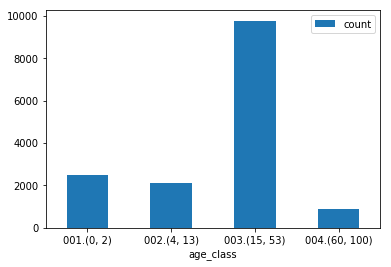

In [73]:
import matplotlib.pyplot as plt
from collections import Counter


# Method for plotting number of images by age groups
def plot_n_by_group(class_column):  
  
  # Count number of images classified by age groups
  count_group = Counter(class_column)
  
  # Convert to DataFrame
  df_count = pd.DataFrame(count_group.items(), columns=['age_class','count'])
  
  # Plotting number of sample size by age groups
  df_count.sort_values('age_class', ascending=True)[['age_class', 'count']].plot.bar(x='age_class', y='count', rot=0)
  
print('Total number of data is {:,}'.format(df_dataset.shape[0]))
plot_n_by_group(df_dataset['age_class'])

&emsp;&emsp;As a result, most facial images are belonged to age group between 15 and 53 years. And the smallest sample size is age group of elders.

In [0]:
# Preview the dataset

# Set dataframe display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

print('Preview dataset')
df_dataset.head()

Preview dataset


,link,user_id_x,face_id_x,link_pic,aligned_image,file_txt_name,user_id_y,face_id_y,original_image,age,age_class
0,/content/gdrive/My Drive/Colab Notebooks/Age Classification/data/aligned/100003415@N08/landmark_aligned_face.2174.9523333835_c7887c3fde_o.jpg,100003415@N08,2174,100003415@N08.2174.9523333835_c7887c3fde_o.jpg,landmark_aligned_face.2174.9523333835_c7887c3fde_o.jpg,fold_4_data.txt,100003415@N08,2174,9523333835_c7887c3fde_o.jpg,"(25, 32)","003.(15, 53)"
1,/content/gdrive/My Drive/Colab Notebooks/Age Classification/data/aligned/100003415@N08/landmark_aligned_face.2174.9529380116_084ce5f5f1_o.jpg,100003415@N08,2174,100003415@N08.2174.9529380116_084ce5f5f1_o.jpg,landmark_aligned_face.2174.9529380116_084ce5f5f1_o.jpg,fold_4_data.txt,100003415@N08,2174,9529380116_084ce5f5f1_o.jpg,"(25, 32)","003.(15, 53)"
2,/content/gdrive/My Drive/Colab Notebooks/Age Classification/data/aligned/100003415@N08/landmark_aligned_face.2174.9529397392_fd7b1e8ba7_o.jpg,100003415@N08,2174,100003415@N08.2174.9529397392_fd7b1e8ba7_o.jpg,landmark_aligned_face.2174.9529397392_fd7b1e8ba7_o.jpg,fold_4_data.txt,100003415@N08,2174,9529397392_fd7b1e8ba7_o.jpg,"(25, 32)","003.(15, 53)"
3,/content/gdrive/My Drive/Colab Notebooks/Age Classification/data/aligned/100003415@N08/landmark_aligned_face.2174.9526641039_f72415beb0_o.jpg,100003415@N08,2174,100003415@N08.2174.9526641039_f72415beb0_o.jpg,landmark_aligned_face.2174.9526641039_f72415beb0_o.jpg,fold_4_data.txt,100003415@N08,2174,9526641039_f72415beb0_o.jpg,"(25, 32)","003.(15, 53)"
4,/content/gdrive/My Drive/Colab Notebooks/Age Classification/data/aligned/100003415@N08/landmark_aligned_face.2174.9524511337_2d3c153c15_o.jpg,100003415@N08,2174,100003415@N08.2174.9524511337_2d3c153c15_o.jpg,landmark_aligned_face.2174.9524511337_2d3c153c15_o.jpg,fold_4_data.txt,100003415@N08,2174,9524511337_2d3c153c15_o.jpg,"(25, 32)","003.(15, 53)"


## **Section 3: Data Preparation**

### **Down sampling**
&emsp;&emsp;As a result shown in bar chart by age groups, it means that data is not balanced class which could lead to interfere the mdodel performance. In addition, although the Google Colab provides a free service for coumputation by GPU, it limits only 12-GB RAM and restricts to 12-hour at a time. According to the unbalanced classes and limitation, down sampling will be done. Therefore, the data will be down sampling based on the smallest size of age group.

Total number of data is 3,488


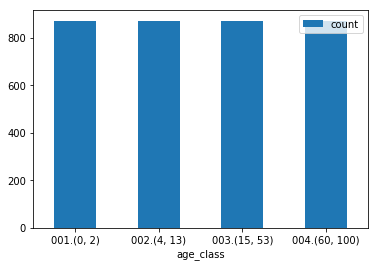

In [74]:
# Count number of images per age groups
count = df_dataset.age_class.value_counts()

# Find the smallest size
n_samp = count.min()

df_dataset_under = pd.DataFrame([])

for i in df_dataset.age_class.unique():
  a = df_dataset[df_dataset['age_class'] == i]
  a_under = a.sample(n_samp, random_state=30)
  df_dataset_under = df_dataset_under.append(a_under)
  
print('Total number of data is {:,}'.format(df_dataset_under.shape[0]))
plot_n_by_group(df_dataset_under['age_class'])

### **Splitting data into training, validation, and test dataset**

&emsp;&emsp;The split ratio is 60:20:20 for training, validation, and test dataset, respectively. For transfer learning model, the model will be trained on the training dataset and validated on the validation dataset.

In [75]:
import numpy as np
import random
import shutil
from tqdm import tqdm


# Method for splitting
def split_trn_val_tst(df, random_state):
  
  # Set seed of random
  np.random.seed(seed=random_state)
  random.seed(random_state)

  nb_class = len(df['age_class'].unique())

  # List index number of each age group
  id_age_gr = []
  for i in sorted(df['age_class'].unique().tolist()):
    a = df.index[df['age_class']==i].tolist()
    id_age_gr.append(a)

  # Stratify random sampling row number by age group
  id_trains = []
  id_vals = []
  id_tests = []
  for j in id_age_gr:
    id_size = np.array(j)
    random.shuffle(id_size) # Shuffle numbers before splitting

    # Splitting into 3 dataset: train, validate, and test
    train, validate, test = np.split(id_size,
                                     [int(0.6*id_size.shape[0]),
                                      int(0.8*id_size.shape[0])])
    id_trains.extend(train.tolist())
    id_vals.extend(validate.tolist())
    id_tests.extend(test.tolist())

  # Store training, validation, and test dataset in dataframes
  df_train = df.loc[id_trains,]
  df_val = df.loc[id_vals,]
  df_test = df.loc[id_tests,]
  
#   # Copy-pasting training, validation, and test images to specific folders
#   # Run this code only once
#   for label_folder in sorted(df['age_class'].unique().tolist()):
#     # Training data
#     if not os.path.isdir(path+'/data_train/'+label_folder):
#       os.makedirs((path+'/data_train/'+label_folder))
#     else: 
#       pass
#     for name in tqdm(df_train.loc[:,'link'][df_train['age_class']==label_folder].tolist()):
#       shutil.copy(name, path+'/data_train/'+label_folder)
#     # Validation data
#     if not os.path.isdir(path+'/data_validation/'+label_folder):
#       os.makedirs((path+'/data_validation/'+label_folder))
#     else: 
#       pass
#     for name in tqdm(df_val.loc[:,'link'][df_val['age_class']==label_folder].tolist()):
#       shutil.copy(name, path+'/data_validation/'+label_folder)
#     # Test data
#     if not os.path.isdir(path+'/data_test/'+label_folder):
#       os.makedirs((path+'/data_test/'+label_folder))
#     else: 
#       pass
#     for name in tqdm(df_test.loc[:,'link'][df_test['age_class']==label_folder].tolist()):
#       shutil.copy(name, path+'/data_test/'+label_folder)

  # Create y_train, y_val, y_test     
  y_train = df_train.iloc[:,-1]
  y_val = df_val.iloc[:,-1]
  y_test = df_test.iloc[:,-1]

  print('y values: {}'.format(list(df['age_class'].unique())))
  print('Size of training dataset: {}, stratified to {}'.format(df_train.shape[0],Counter(y_train)))
  print('Size of validating dataset: {}, stratified to {}'.format(df_val.shape[0], Counter(y_val)))
  print('Size of test dataset: {}, stratified to {}'.format(df_test.shape[0], Counter(y_test)))
  return df_train, df_val, df_test, y_train, y_val, y_test
  
df_train, df_val, df_test, y_train, y_val, y_test = split_trn_val_tst(df=df_dataset_under, random_state=30)

y values: ['003.(15, 53)', '004.(60, 100)', '002.(4, 13)', '001.(0, 2)']
Size of training dataset: 2092, stratified to Counter({'001.(0, 2)': 523, '002.(4, 13)': 523, '003.(15, 53)': 523, '004.(60, 100)': 523})
Size of validating dataset: 696, stratified to Counter({'001.(0, 2)': 174, '002.(4, 13)': 174, '003.(15, 53)': 174, '004.(60, 100)': 174})
Size of test dataset: 700, stratified to Counter({'001.(0, 2)': 175, '002.(4, 13)': 175, '003.(15, 53)': 175, '004.(60, 100)': 175})


### **Generating batch dataset**
&emsp;&emsp;According to the limitation of computational resource, model should be trained on batch. The batch is generated and calculated by using the 'ImageDataGenerator' which is availble in Keras library. In addition, augmentation will be done on shearing, zooming, ratating, and horizontal flipping to avoid model overfitting.

&emsp;&emsp;To train on batch based on file path, the function of 'flow_from_directory' will be used. For this method, images have to be store in the correct folder named by age groups. Also, these folder is stored separately due to purposes of training, validation, and testing. Additionally, according to model architecture of VGGFace, the input layer is fixed size to 224x224 pixel of images.

In [76]:
from keras.preprocessing.image import ImageDataGenerator


# Augmentation configuration for training
# To avoid overfitting of model
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   horizontal_flip=True)

# Augmentation configuration for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Augmentation configuration for test
test_datagen = ImageDataGenerator(rescale=1./255)


# Method for feeding data as batch file
def data_flow_from_dir(img_generator, path_folder, df, batch_size):
  dataflow = img_generator.flow_from_directory(directory = path_folder, # target directory
                                               classes = sorted(df['age_class'].unique().tolist()),
                                               target_size = (224, 224),
                                               class_mode="categorical", # use categorical for multiclassification
                                               batch_size=batch_size,
                                               seed=30
                                              )
  return dataflow



# Specify number of images for feeding into the image generator function
batch_size=32

# Prepare data for batch training and validaion
# Set folder path for train and validation dataset
path_train = path+'/data_train/'
path_val = path+'/data_validation/'
path_test = path+'/data_test/'

# Augmentation
train_data = data_flow_from_dir(train_datagen, path_train, df_train, batch_size=batch_size)
val_data = data_flow_from_dir(val_datagen, path_val, df_val, batch_size=batch_size)
test_data = data_flow_from_dir(test_datagen, path_test, df_test, batch_size=batch_size)

# Calculate batch size per epoch
train_per_epoch = round((df_train.shape[0]/batch_size)+0.5)
val_per_epoch = round((df_val.shape[0]/batch_size)+0.5)
test_per_epoch = round((df_test.shape[0]/batch_size)+0.5)

Found 2092 images belonging to 4 classes.
Found 696 images belonging to 4 classes.
Found 700 images belonging to 4 classes.


## **Section 4: Model Architecture**
&emsp;&emsp;As metioned above, transfer learning model is based on VGGFace model with weight pretrained on VGGFace dataset. Generally, major architecture of VGGFace is consisted of input layer, five hidden layers of stacked convolution, two fully-connected layers and output layer as shown below.

![VGGFace model](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/08/vgg-face-model.png?ssl=1)

![](https://i2.wp.com/sefiks.com/wp-content/uploads/2018/08/layer-details-in-vgg-face.png?w=1645&ssl=1)

[Pic: Deep Face Recognition with Keras](https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/), For more detailed information, original paper is available from [Deep Face Recognition](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf).

In [0]:
# Install the keras_vggface module
!pip install keras_vggface

from keras_vggface.vggface import VGGFace
from keras.utils import print_summary
from IPython.display import Image

# Create model which includes all layers of VGGFace model and the pretrained weight.
model = VGGFace()

# Display model summary
print_summary(model, line_length=150)

W0820 13:51:13.381881 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 13:51:13.425567 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 13:51:13.436415 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0820 13:51:13.510460 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



580075520/580070376 [==============================] - 8s 0us/step


W0820 13:51:22.897306 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0820 13:51:22.899174 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_1 (InputLayer)                                               (None, 224, 224, 3)                                         0                      
______________________________________________________________________________________________________________________________________________________
conv1_1 (Conv2D)                                                   (None, 224, 224, 64)                                        1792                   
______________________________________________________________________________________________________________________________________________________
conv1_2 (Conv2D)                                                   (None, 224, 224, 64)       

&emsp;&emsp;Model training can transfer whole architecture and pretrained weight from the pretrained model, except the output layer. Because the number of nodes in output layer of classification model should be related to number of classes. However, due to different purpose of model, it needs to modify some structure or re-train weight of some layers to improve model performance which aim to classify age groups.

## **Section 5: Hyperparameter Settings**
&emsp;&emsp;Basically, tuning hyperparameters of transfer learning is commonly related to reconfigure the number of trainable layers, number of nodes within other adding layers, and model learning rate.

### **Method for model creation**

In [0]:
from keras.layers import Flatten, Dense
from keras.engine import  Model
from keras import optimizers


# Method for modify VGG16
def create_model():
  
  # Call VGGFace model
  model = VGGFace()
  
  # The first 18 layers are freezed, 
  # so the weight of these layers will not be constant during model training
  for layer in model.layers[:18]:
    layer.trainable = False  
  
  # Specify the last layer of pretrained model that will be used
  # Use whole architecture of VGGFace, except the last two fully-connected and output layers.
  layer_name = 'flatten'
  x = model.get_layer(layer_name).output
  
  # Add more hidden layers
  x = Dense(16, activation="relu")(x)
  
  # Add 4 nodes corresponding with 4 groups of age
  out = Dense(4, activation="softmax")(x)
  
  # Create the final model
  vgg_model_new = Model(input = model.input, output = out)

  # Compile the model
  # Calculate loss by 'categorical_crossentropy' function because of multiclassification model
  # Set metrics equal to 'accuracy' because of balanced dataset
  # Reduce learning rate to slow down training process
  vgg_model_new.compile(loss = "categorical_crossentropy",
                        optimizer = optimizers.Adam(lr=0.0005), 
                        metrics=['accuracy'])
  return vgg_model_new

model = create_model()

# Display model summary
print_summary(model, line_length=150)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
W0820 13:51:36.236164 140408626956160 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
input_2 (InputLayer)                                               (None, 224, 224, 3)                                         0                      
______________________________________________________________________________________________________________________________________________________
conv1_1 (Conv2D)                                                   (None, 224, 224, 64)                                        1792                   
______________________________________________________________________________________________________________________________________________________
conv1_2 (Conv2D)                                                   (None, 224, 224, 64)       

&emsp;&emsp;As a model summary, only 401,492 (approximately equal to 2%) parameters will be trained, so the model will spend less time on training compared to new model development.

### **Method for model training**

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, TerminateOnNaN, Callback


# Function for tuning hyperparameters and get the best model
def model_training(df_train, df_val, train_data, val_data, train_per_epoch, val_per_epoch):

  # Define list functions to be applied in Callbacks

  # 1.Early stopping when val_loss is not reduced less than min_delta value
  es1 = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.0005, patience=10)
  
  # 2.Early stopping when val_acc is not increased more than min_delta value
  es2 = EarlyStopping(monitor='val_acc', mode='max', min_delta=0.001, patience=10)
  
  # 3.Early stopping when loss is NaN
  tn = TerminateOnNaN()
  
  # 4.Model checkpoint: to save the best model
  path_model = '/content/gdrive/My Drive/Colab Notebooks/Age Classification/model/'
  mc = ModelCheckpoint(path_model+'bestmodel.h5', 
                       monitor='val_acc', verbose=0, save_best_only=True, mode='max')

  cb = [es1, es2, tn, mc]
  
  
  # Fix seed number to obtain reproducible result
  np.random.seed(30)  # Set seed number for Numpy
  random.seed(30) # Set seed number for core Python
  tf.set_random_seed(30) # Set seed number for TensorFlow backend  
  
  model = create_model()
  
  # Train model
  fit_model = model.fit_generator(train_data,
                                  steps_per_epoch = train_per_epoch,
                                  epochs = 200,
                                  validation_data = val_data,
                                  validation_steps = val_per_epoch,
                                  workers = 8,    # To fasten calculation of GPU
                                  verbose = 1,
                                  callbacks=cb
                                 )

  # Keep accuracy and loss values all epoch
  history_dataframe = pd.DataFrame(fit_model.model.history.history)
  

  
  return history_dataframe, fit_model

## **Section 6: Model training and Evaluation**

In [0]:
# Model training
history_dataframe, fit_model = model_training(df_train, class_wt, df_val, train_data, val_data, train_per_epoch, val_per_epoch)

# Display model learning by epochs
history_dataframe[['acc','val_acc']].plot()
history_dataframe[['loss','val_loss']].plot()
plt.plot()

![accuracy](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYUAAAEBCAYAAACXArmGAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xl8VOXd///XObNkIeskk2RCgECA%0AEPZFWQREqQutoaEoarF+7c8Wb0qr9dv6tdH6A7XWr7He3m29Ubtob61rFRUIiNQuKgiIgLKEnUBI%0AMkyWyZ5JZjnn+8eECRGQJExIZvJ5Ph55mOXMmetcHs57rutc57oUXdd1hBBCCEDt7QIIIYToOyQU%0AhBBCBEgoCCGECJBQEEIIESChIIQQIkBCQQghRICEghBCiAAJBSGEEAESCkIIIQIkFIQQQgRIKAgh%0AhAiQUBBCCBEgoSCEECLA2NsF6KyamiY0TSZ0TUqKobq6sbeL0SdIXbSTumgndeGnqgqJiQO6/LqQ%0ACQVN0yUU2kg9tJO6aCd10U7qovuk+0gIIUSAhIIQQoiAkOk+Ohdd16mpqcTtbgH6R3OxokJF07SL%0A3IuC2RxJYqIVRVGCUi4hRHgI6VBobKxDURRSUzNQlP7R6DEaVbzeiwsFXdeora2isbGO2NiEIJVM%0ACBEOQvpK6nI1Ehub0G8CIVgURSU2NhGXS0ZoCCE6Cumrqab5MBhCurHTawwGI5rm6+1iCBGydD08%0Au6xD/ooqfeLdI/UmRNdous5JRyNFJ5zsP17DodJadB2iIoxERRiJjjAEvo+KMBJlNhIVYSD6zN9F%0AGkmKiyQ1MarP/hsM+VAQQoieoOs6jhoX+487KTpRw4ETNTS1eAFITx7AzHE2IowGmlu9uE5/ub3U%0ANrpxtXppbvXS6j53azwmysSIjHhGZCQwPCOezLRYjIaL67jRNB27s5nj9nqO2xtobPHw0A+md3k/%0AEgpCCNGmpqGV/W0tgaITNdQ0tAJgiYtg0ggrOZmJ5AxJJCEmolP70zQdl9uLq8UbCA9HjYvDpbUc%0ALq1j1+EqAExGlaFpsYwYlMCIjHiyBsYzINJ0/v3qOhU1Ln8AnGrguL2eE45GWj3+EIowG5g4Irlb%0AdSChEESPPPIQJSUn8HjcDBw4iAceWE5cXByFhat56603ADCZTDz55H9hsSSxefMnvPjiH/F6vaiq%0Awi9/+QjDh4/o5aMQon/QdJ3KGhfFp+o5WlpP0Qkn9upmwP9JftTgBHIyLYwekkhKN7t7VFVhQKSp%0AwwU+e3AiV05IB6Cuyc2RtoA4XFrHhm0lrNviv1cx0DqAERkJjBgYz0DrABxtIVBsr+eEowFXqz8A%0ATEaVwakxzB5vI9MWS2ZaHGmWaIzG7rU8FD1E7pZUVzee9ej6qVMnSEsbAsDmPXY27bb3yHvPGm9j%0A5jjbBberra0lIcE/xPOPf3wWn8/HtGkzKCh4jGef/TNJSck0NzdjMBhwOE7xk5/cxcqVf2LQoMG4%0A3W68Xg/R0V8/V0kwhqSedmb9hSKrNZbKyobeLkafIHXR7lx1oes6VXUtgU/Vx081cPxUA65Wf3eQ%0A2aQyclACo4dYyBmSyKDUGNRe6PNv9fgoLq/3tyTK6jhaVhe4+AMYVIVBKTFk2uIYmhZLpi2O9ORo%0ADOrZAaCqCklJMV0ug7QUgmjDhkI2btyA1+vB5Wph0KDBaJrGvHk3kJTkb8pFR0cDsH37NqZPv4JB%0AgwYDYDabMZvNvVZ2IcKFrus469sC4JS/f/34qQYaXR6g/cI6bXQqmWmxDP2aC+ulFmEyMGpIIqOG%0AJAL+7qeyqibKKhtJS4pmYHIMpm62ADorbEJh5rjOfZrvKV9+uYv33lvFc8+9SGJiIhs3bmDNmnd6%0ArTxC9Bd1Te5At8rxUw2UVDRS23YvQFUUMqwDmDwymcy0ODJtsZfkwhosaluADUrp+if+7gqbUOht%0ADQ0NDBgQQ3x8PG63m3Xr1gAwY8ZMCgoeIy9vIRZLUqD7aOrU6bz00gucPFnSpe4jIfqzhmY3J041%0AUHxGN9Dpm8GKAulJA5icnYItMYrMtFgGpcRgNhl6udShRUIhSKZPv4KNG9/nu99dSHx8AhMnTqKo%0AaB+TJ1/G7bd/n3vvXYaiqJjNJgoK/otBgwZz//2/ZMWKB/D5NAwGlV/+8hGysob39qGIMNfq9vHh%0AjpMUHa9hwvBkpo9JJS66Z7ouNU3n4MlayquaMBoUTEYVo0HFZFQxGdq/D/y37fcmo4qu65RWNHL8%0AjBCoqmsJ7DvVEk32oAQy2/rWB6fGEGk2yv2VixQ2N5r7C7nR3E7+8bfrTF14vBoffVFG4afHqW/2%0AkBwfSVVdCwZVYcLwZGaNszEuy3LRfeu6rnP8VANb9zn47ICDukb3Re0PIDk+ssPN1SGpsURHnvsz%0ArZwXfnKjWQhxTj5N49O9p1izqZjq+layByXwk4VZDM+Ip7SykU277Wzdd4qdhyqJG2DmijFpzBxv%0AY2By17oyy6ua2FbkYNt+BxU1LowGhXHDkpg+Jo2RGfH4NB2PT8Pr1dr+6//Z49XwfuW/Hp+Grumk%0AWweQmRZHTNT5x+yL4JJQECJMabrOjoOVvPvxMU45m8lMi+X738xhdGZiYMx9hjWGW78xgpuuymLP%0A0Wo27bHz989PsuGzEobaYpk1zsa00alEn+dBquq6Fj7b72BbkYOSikYUBXKGJHLD9CFMybae93Wi%0A75JQECLM6LrOnmNO3vn4KCWORtKTB/Dj74xj8sjk8z6AZTSoTBppZdJIK/VNbrbuO8WmPXb+uvEQ%0Ar//jCJNHJjNrvI3RQyw0tnj4/EAF24ocHC6tA2BYehzfvWYEU0elEN/Jp31F3yShIEQYOXSylnc+%0AOsqh0jqS4yP5wQ05zBiThqp2/kGsuAFmrps6mGsvH8QJRwObdtvZVuTgs/0VxA0w09jsQdN1BiYP%0AYOGVw5g6OpWUhKgePCpxKUkoCBEGjpbW8sLqvew5Vk38ADPfu24kV05Iv6hJ1hRF8Y/tT4vjlrnD%0A2XW4is8PVpKSEMX00alkXMKx8+LSkVAQoo9we3xsP1BBk8tzxg1Y/bw3Yk//3Or2UVLRyIBII4uu%0AymLulAwigjw232Q0MDUnlak5qUHdr+h7OhUKxcXF5OfnB+b2KSgoIDMzs8M2lZWVLF++nNLSUrxe%0AL0uXLiUvLw+AZ555htdee42UlBQAJk+ezIoVK4J7JEKEsD3Hqnl14yEqal0dfm80KGeN5e84vl8h%0ALsbMdydmM3N06nmHaQrRWZ06g1asWMHixYvJy8tj9erVLF++nJdffrnDNk888QRjx47lueeew+l0%0AsnDhQqZOnYrN5p96YsGCBfziF78I/hEIEcKc9S28/o/D7DhYSZolmp/fMpGhtjhMRgWDQe30pGwy%0ANl8EywU7HKurqykqKiI3NxeA3NxcioqKcDqdHbY7cOAAs2fPBsBisTBq1Cjef//9Hihy+PjJT+5i%0A8+ZPersY4ms0t3g5dLKWuqaLfwDrTF6fxoZtJfzyT9vYfbSahVcO45E7pzJmqIXoSCMmo6FXZukU%0A4oItBbvdTmpqKgaDv4/SYDCQkpKC3W7HYrEEthszZgzr169n3LhxlJaWsmvXLjIyMgJ/X7duHZs2%0AbcJqtXL33XczadKkoB6I59BmPAc/Duo+TzNlX4lp5Mwe2bfoO1rdPk44GgKzaxbbG3A4/fPrq4rC%0A+KwkZo6zMWF40kXdwD1cWstfPzhIaWUT47OSuO3akVhl9I7oI4LWAZmfn8/jjz9OXl4e6enpzJgx%0AIxAkt956K0uXLsVkMrF582aWLVvG+vXrSUxM7PT+z/W4dkWFGlhIwqcqPbbmqaoqF1yw4sUX/0x9%0AfS333nsfAHV1tdx880KWL3+Ev/zlz7jdbnw+H9///g+49trrAf/oDoPh/Pv2er38/Of3UFdXR2tr%0AK6NHjyE//yFMJv8DQS+99CIbN25AURSioqL4wx9eRFVV1q59jzfffB3wL+rz1FO/Iykp6RzHpWK1%0Axna7XvqC7pbf7fFRXF7HkZO1/rnrT9ZS6mjg9EwqSfGRDM9I4Nqpgxlii+PAcSf//PwkXxypIm6A%0AmaumZHDN5YMZmh7f6fesa2zlpXVF/P2zEpITonjw+1OZPjYtaOdtqP+/DCapi+67YCjYbDYcDgc+%0Anw+DwYDP56OioiJwr+A0i8XCU089Ffh5yZIlDB/un9zNarUGfj9z5kxsNhuHDx9m6tSpnS7oueY+%0A0jQtMA+QYfgVRA2/otP766oLzTd03XXf4j/+4w6WLr0Ho9HI+++vZ+bM2eTkjGPlyj9jMBhwOqv5%0AwQ9uZ8qUacTFxaHrOj6fft5967rC8uWPER+fgK7rPPbYCtauXc23v72Q998v5OOPP+K5514gOnoA%0AdXW1aBp8/vln/M//vHjWoj7neg9N00K6H7qz/ehen0ZZZRPFgbn16ymrbMLXdj7FRpsYaotj4hWZ%0AZNriyEyLPWu5xazUGOZdnsHeY0427bGzblMxaz4+xpDUWGaOS2P6mLTzTsWg6Tqbdtt5619HaHH7%0A+Oa0wXx75lAizAaqqhovviKQewpnkrrw67G5j5KSksjJyaGwsJC8vDwKCwvJycnp0HUEUFNTQ2xs%0ALEajkS1btnDo0CF+//vfA+BwOEhN9Q9l279/P2VlZQwdOrTLhe3L0tLSyMzMYuvWzcyaNYf16wu5%0A556fUVtbw//9v49SWlqCwWCkvr6OkpITjB077oL71DSN119/ha1bP0XTfDQ0NBAd7e9m2Lz5ExYs%0AuDEw1XZ8vH/Fty1bNp9zUZ/+wqdp2Kua/QHQNrPmyYpGvD5/AAyINJKZFsu8aYPJTItjqC2WxNiI%0ATn1aN6gqE4YnM2F4Mo0uT+Cp39c+PMzf/nWEicP9T/2OGdo+qVyJo4G/bjzI0bJ6RmbE873rs8mw%0Ayvh+0Xd1qvvo4YcfJj8/n2effZa4uDgKCgoAf2vgnnvuYdy4cezevZtf//rXqKpKYmIizz//PFFR%0A/gvY008/zb59+1BVtW2N4ic7tB7Cxbe+lcv77xdisw2kqamRCRMmce+9y5g580oef/w3KIrCrbcu%0AxO1u7dT+/v73Deze/QXPPvsnoqMH8PLLL1JaerKHjyJ0aJqOvbqJ4/aGQCugxNGAu61VFBVhYEhq%0ALNdcNigwvbI1PjIo3TUxUSauuWwQ11w2iBJHA5v22Nm6z8HnByuJjzFzxdg0vF6df+woZUCUkR/c%0AkMMVQewqEqKndCoUsrKyeOutt876/Z/+9KfA93PmzGHOnDnnfP3pEAl3c+bM5ZlnnuaNN17hm9/M%0ARVEUGhoasNlsKIrC9u1bKSvr/EW9sbGB+PgEoqMH0NjYyN//voGcnDEAzJw5m/feW8WcOVcHuo/i%0A4xPOu6hPRET4zEfj8Wq8+vdDbD9Q0WGN3SGpscyZOLBt8fJYUi3Rl2QEz+DUWBanxnLz1cP58kg1%0Am/fY+WDbSXRdZ87EdBbOyZJZPkXIkCddgigyMrKt62gtf/ubf+W1H/3oJ/znfxbwwgt/JCdnNFlZ%0AIzq9v3nzcvnkk49ZvPhGEhMtTJgwCbfb3fa3G6isrOCuu/4/jEYjUVFRrFz5p/Mu6hMuodDo8vDf%0A7+zh0MlavnH5IIZYY8i0xZKeNKBL8/v0BKNBZUq2lSnZVuqa3LR6fDInkAg5sshOiOnPi+xU1rr4%0A7VtfUlnr4s5v5TD/qhFyQ7GN3FxtJ3XhJ4vsiLBWbK/nd299iden8/NbJpI9uPPDmYUQnSeh0Af8%0A5jePs2/f3g6/MxgMvPDCX3upRH3LF4ereH7NXmKjzNy/eALpXVwRTAjReSEfCrquh/yIjv/zfx68%0A5O8ZIr2G/HNnKa/+/RCDU2O596bxsoCLED0spENBVQ34fF6MRhnZ0VU+nxdVDe70ysGk6Tpv//so%0AG7aVMCErif/IG0OkOaRPVyFCQkj/K4uKiqGhoZaEhCQUpftz0fQ3uq7R0FBDVFTffIjK4/Xx58L9%0AbD9QwdWTBrL42hGBh8GEED0rpEMhJiaemppKHI5SIDS6Qy6Wqqpo2sWOPlIwmyOJien8vD2XSqPL%0AwzOrdnO4tI5FV2Uxb9rgkO8eFCKUhHQoKIqCxZLS28W4pMJ5uF1FrYv/+tuXVNe5WJo3Rlb5EqIX%0AhHQoiPBxrLye3739JZqmc9+tkxg5KKG3iyREvyShIIJG13Wq6lq6PLLp+KkGXly3n7gBZv73zROw%0AJcmQUyF6i4SCCIoWt5eV7+5lX7Hzwhufw1BbLPfcNIH4AeYgl0wI0RUSCuKiNbo8/O6tLzlmr+c7%0As4eSFB/ZpdcbDf4pqSNMfXeIrBD9hYSCuCi1ja3855tf4HA2s2zBOKZkh9+U6EL0JxIKotsqa108%0A9cYu6ps83LtoAqMzLRd+kRCiT5NQEN1SVtnIU29+gdercd93J5LVhbWKhRB9l4SC6LKj5XX89m9f%0AYjSq/OK2ybK8pBBhREJBdEnRcSfPrNpD3AAT9906CassIiNEWJFQEJ2242Alf1izl1RLND+/ZSIJ%0AMmOpEGFHQiGM1Te5KdxynF2HKhmRkcDkkVbGDUsiwtz1oZ+bdtv5y/v7GWaL46eLJsiaw0KEKQmF%0AMNTc4mHDZyX8fXspHq/G6KGJ7C12srXIgcmoMnaohSnZViYMT2ZA5IUv7hu3n+SNfxxmTGYiP144%0ATqawFiKMyb/uMNLq9vGPnaW8v/UETS1epuaksGD2MNIs0fg0jcMn69hxqJKdhyrZdbgKg6owakgi%0AU0ZamTQi+awFbHRdZ/WmYtZsPs6UbCt3zR+DyShTWAsRzhQ9RJbgqq5uRNNCoqg96lyzpHp9Gh99%0AUU7hp8epa3IzPiuJhVcOY3Bq7Dn3oek6x+0N7DhUwY6DlVTUuFCA4RnxTBlpZfJIK5b4SF7/8DD/%0A2FHKrPE27piX3efWNAjnGWM7Q3PV4ysrwle+H5O3kVa3t7eLdF6KOQo1MQODZSCqJQMlJrnHpkTv%0A7+fFaaqqkJTU9ZGBEgoh5swTXtN0tuw7xepNxVTVtTByUAI3zhnGiIzOzzCq6zplVU3sPFjJjkOV%0AnKxoBMASF4GzvpXrpw7i5quH98k1DfrbP37d7cJ36iDesv34yvahOUv9fzBHY05Mxeu72HU2eo7e%0A0ojeWN3+C1MkqiUDQ2IGaltQGCyDUCIvfnhzV84LzVWPr3w/elMNxqxpqAMSL/r9LzVd18HdjO5q%0AQHPVobvq0VsaUNGwzflOl/cnoRBirNZYKirq2Xmoknc+Poa9upkhabHcOGcYYzItF33xrqhpZueh%0AKvYWVzN+WBLXXj6oTwYChH8o6D4vvoqj+Mr24S0rQqsoBt0HBhOGtJEYBuZgTB+NmpxJSmp8n68L%0A3e1Cc5bic5aiOUvRavzf09oU2EaJTkC1ZKAmDsRgyUC1DEJNTEcxdn6ixK87LzoGaxGa82T7H1UD%0AxmFTMY+7HoM1s7uHGVS6141WW45WU47uqjvjwt/gv/i3faGd3Uo0xlsZ/JPnu/yeEgohRNd1Smta%0AeHHNXk6casCWFM13Zg9jSra1z164e1K4hYLu86A5y/CVF+EtK8J36hB43aAoqNahGNNHYxg4GkPq%0A8LMukqFaF7quozfX+kPCWYqv5nRglIPP499IUVDiUv0hkXhGqyIuBeUcXZpn1kV7sBbhLdt3RrAa%0A/cGaPhrjwNEo5mjcRf/Ac/AT8LRgSBuJaey1GDMno1yCtcx1TUOvr2g//rbw1OsdcOYlWjWiRMV1%0A+FK/8vPpL0N0HMnWrs80IKEQIjRd589ri9ha5CApLpK8WUOZMTa1z/XzX0qheyHU0Buq2j8xn/6q%0AOwW6vwtITUzH0BYCRls2SsTXrzERqnVxPv6LpKNDHflqStHrKggsvWswoyamt4XEwLZWxUASIr1U%0A7d1+drAmD8U48PzBCqC7m/Ec/AT33g/RGypRYpIwj70GU/aVF/x/0Knj0nV0V13bMZ3E5yw7IwTd%0AbVspKHEpbS2ltq/EdH/Xlimq0x8A5Z5CmPvbv46wYVsJt1w7krkT0mUUEKFxIdRc9R0u/D5nKVpN%0AGXhbA9sosdYzLgCDMKSN6HLfdijURTDo3la0mvKO3VDOk/4ulK9QE9IxDMzBMHBMp4K1w/toGt6S%0AXXj2bMRnPwjGCEzZszCPvRY1Pq1z+3C70GrK2sp5Eq0tAPTWxsA2SlScP8wsGe3nQEI6iuniHwyV%0AUAhj/95VxssfHOTqyQP534unUFXVeOEX9QN97UKo6zpabbl/RFBZEb6Kox0uVkpkbPsnv9MXgcSB%0AKKaurT9xLn2tLi41zVWPVuO/6MYlJ9EcOzRoN419VSdw792I98g20HwYBo/333dIz0FRFHTNi1Z7%0A6ozgP4lWU4beUNW+E2MEquWM+ySnu8Ki4oJSxnORUAhTe49V89u3djNmqIV7bhpHWgjcUOwMXdfR%0A6x3+G6jVJRizpmFMz+nSPrp6IfSW78d7+FOU2OT2funYZBSl+60urbG6rb/aPzRUb64F2j7927Ix%0AnL4AWDJQo3tuJtn+Hgpn6qm60Jpr8RT9C0/RP/2jexLSQVHR6uyg+fwbKSpqQhpqYkbgHFMtGSix%0ASRd1nnVHd0NBHl7rw0orGnn2vb2kJw9gad6YkL9/oDXXtl1A9+MrL2ofomgw4tn/b4zDZxAx/dag%0AXzy15lpat76J98gWMEWCp6X9j8aItpEuAwPdN6ol47yf4PSWRrzl+wNBoNc7AH83gP8eQA7GgaNR%0AY2WxoXCjRicQcdl3ME+8Ae/RbXgObQJjBObB49vPnYQ0FENoTwEjodBH1Ta28tu3vyTSbODeReOJ%0Aiuj5/1W6t/WMYW4NYDCiRMWjRMWiRMZ2eRSG7m7GV34Qb3mRf1x9Tbn/DxEDMKbnYJh4A8b00Sgx%0Aibh3FeL+cj3eki+JmHoTplFXnXNkSZfeX9Pw7P8nrdtXgdeDeXIe5ok3gK6d0dfr//Ke+AL94CeB%0A1/r7etua+IkD0epO4Svbj1ZdAuhgisRgy8Y4Zi6GgaNREzP65Qiw/kgxmjFlz8aUPbu3i9IjOnWl%0AKS4uJj8/n9raWhISEigoKCAzM7PDNpWVlSxfvpzS0lK8Xi9Lly4lLy8PAJ/Px2OPPcYnn3yCoijc%0AddddLFq0KOgHEy5a3T5+9/Zumlxe8m+bjCWu+33Ouq6j1znQmms6jGs+/aWd/r6loeMn6LMoKJEx%0AbQFx7iFwalQcutft/xRdXoRWWewfTmcwY7CNxDxilv9TdNLgsy74EZffiGnEFbRsepnWTS/jOfgJ%0AkbPu6PZ4cV9lMS2fvIRWdRzDwDFEzrwdNaH9BqEhJQtDSlbHejrjprCvbRy9Z/9H/lEhqhFDahbm%0AyxZgHDgG1ZqJospnKhF+OnVWr1ixgsWLF5OXl8fq1atZvnw5L7/8codtnnjiCcaOHctzzz2H0+lk%0A4cKFTJ06FZvNxtq1aykpKWHjxo3U1tayYMECZsyYQUZGRo8cVCjTNJ0/rt1HiaOBu28cz5C0c09V%0A0Rle+0Hcn72Nz3G44x8Uxf/JPyoOJSoeNc4aaBGokXEo0XEokXHoPs85g0R31eOrPoHeXA8e19lv%0ArKioKcMwT8zFMHAMhtSsTjWp1QQbUTfcj/foVlq3vE7ze49gGj2XiMtvRDFHd+qY9dYmWrevwlP0%0AL5ToeCK/8SOMw6Ze8FO8oigo0fH+rquMMe370zT0xmp/nRhlqnAR/i4YCtXV1RQVFfGXv/wFgNzc%0AXH71q1/hdDqxWNrX5D1w4AB33HEHABaLhVGjRvH+++9z5513sn79ehYtWoSqqlgsFq655ho2bNjA%0AD3/4wx46rND1t38dYdfhKhZfM4KJw5O7tQ9f1XFat6/Cd3IPSnQCETMWoyYNavuEH+v/xB+km166%0A143e0v50JSgY0kagmLu3+I6iKJiGz8A4aDytn7+DZ98/8R7bTsSM72LMmn7ei7uu63iPbKF16xvo%0ALQ2Yxl5DxGXf6XSYnLc8qooSJ/cHRP9xwVCw2+2kpqZiMPj7kw0GAykpKdjt9g6hMGbMGNavX8+4%0AceMoLS1l165dgZaA3W4nPT09sK3NZuPUqVNdKmh37qKHmnWbi9m4/STzZw/ju98cfd7trNZztx7c%0AVaXUfPQGzQe2oEbFYPnG/yJuyjzUIIx5/npJPbDPWMhYRuu066l6/w+0/PMPRB37lKR5SzAnDQxs%0AZbXG4q4qpeqDP9FyYi8R6SNInvf/E2Eb1gNl6tvOd170R1IX3Re0TtH8/Hwef/xx8vLySE9PZ8aM%0AGYEgCYZwH5K6+2gVf3h3NxOHJ5M3Y8h5h9Sda7id1liNe8d77aMhJudhHn89HnM01bVuwH3OfYUE%0AYwqmG34J+/+Fa/vblP7xZ5gnfBPzpPkkJ8dQvvE13LvfB2MEEbPuwDRqDvWqCv1seKYMSW0ndeHX%0AY0NSbTYbDocDn8+HwWDA5/NRUVGBzWbrsJ3FYuGpp54K/LxkyRKGDx8e2Ed5eTnjx48Hzm45hDKt%0A1o6v4hiGjLHdHkpZ4mjgudX7GJQSw13fHo2qdm4Ui+aqx71rLZ6if4ECprHXYZ54Q48+ENMbFFXF%0APOYbGIdOoXXrm/5jPrKVFlXBW1eBccRMIqbfEnbHLURvuGAoJCUlkZOTQ2FhIXl5eRQWFpKTk9Oh%0A6wigpqaG2NhYjEYjW7Zs4dChQ/z+978HYN68ebz11ltcd9111NbW8uGHH/Lqq6/2zBFdIrq3FffO%0Atf5PqZoPFAXDwDGYsqZhHDql033ZNQ2t/O7t3URHGPnpTRM6taqZ3tqEe/cG3Hs2gs/jf/x+ch5q%0ATE904/QdanQCUXP/A++oK2nd9FcUo0pUbj7G9FG9XTQhwkannmg+evQo+fn51NfXExcXR0FBAcOG%0ADWPJkiXcc889jBs3jo8++ohf//rXqKpKYmIiy5cvJyfH/4Sqz+fj0UcfZfPmzYC/FXHLLbd0qaB9%0AqfvIe+ILWj59Bb2hCuPImZhHXYW35Es8R7ehN1SCwYhx8ET/U7qDJ5x32t8Wt5cnXt2Jo8bFA7dN%0APu+iOKfpbhfmE5txfvoutDZhHDaViMsWdhhq2V/ouo7VGitTfrSRLpN2Uhd+Ms3FJaA1VtP66at4%0Aj+9ETUwnYtYdGG3Zgb/ruo4+DkZwAAAWUElEQVRWcRTPka14j33mH41jisI4dAqm4dP9c6W0PQCm%0AaTr//c4evjxaxU9vGs/4rPaRRrrmQ6s7ddZEanpDJQCGwROIuGwhhuQhl7YC+hj5x99O6qKd1IWf%0ATHPRg3TNi3v3Rtw73wPAPHUR5nHXoxg6Vp+iKBhSh2NIHY4+47v4yvf7A6J4B95Dm1Ci4jAOm4o2%0A5HJW7dP54kgld16VymhTGa1fbAssPKLV2NsXzVBU1Pg0DNahqNmzSB47lQaz7atFFEKIoJCWwgV4%0A7Qdp3fQyWk0ZxiGTiLjiNtTYrj0/oHvdNB7dRe2eT4h17seAj1otmgFGHybtjCmUB1g6zJ7pn0bX%0A1qH7ST4FtZO6aCd10U7qwk9aCkGmuepp3fYm3kObUWKSiLr+pxiHTOrSPmobW9l1qJKdhyo5UNKM%0AT5tMWuwU5tmqGWU8SVSiJTCHusGSEZRFPIQQ4mJIKHyFrmt4DnxM62dvgbsF88QbME/6dqcXvais%0AdbHjoD8IjpbVoQOplmiunzqYKdlWMtNiZeI0IUSfJaHQRtd1tMpiWj59Ba3iGAbbKCJm3Y4hceAF%0AX1tW2ciOQ5XsPFhJSYV/NMzg1BgWzB7K5OwU0pOiJQiEECGh34eCVl/hvxl8dCtaTTlKVByRV9+F%0AcfiMTl3IV310lHVbTqAAWRnx3DJ3OJNHWrEmdG/uHyGE6E39MhS05lq8Rz/Dc3QrWsUxAAxpI4mY%0A9b8wZU3rdN/+rkOVrNtygivGpnHTVVkkxMgsmkKI0NZvQkFvbcJbvAPP0a34yveDrqMmDcY89WZM%0Aw6d1+WngiloXf163n8y0WO6YNwqTMbRXRRNCCAjzUNC9brwlX+A9shVvyW7QvChxKZgnzceYNR1D%0AYvfmX/J4fTz77h4U4EcLxkogCCHCRliGgtZcS+u2t/Ae3wGeFpToBEyj52IaPh3VOvSib/q+/uFh%0AShyN3HPjeLl3IIQIK2EXCj5nGa4NT/sXWsmajnH4dAy2URe93u9pW/ae4t9flPPN6YOZOKJ7i+AI%0AIURfFVah4C3fj2vj71EMZqK//SCG5Myg7r+sspGXPjjAyEEJLLyy/y3iIoQIf2ETCp7Dn9Ly0Quo%0A8alEzftZl6eiuJAWt5dn39tLpNnI0rwxGILU8hBCiL4k5ENB13XcXxTi3r4Kg20UUdfdHfTpInRd%0A56UNBznlbOa+WyfJ0FMhRNgK6VDQNR+tm17Gc+AjjMNnEDnnThSDKejv8+9dZWwrcrDwymHkDEkM%0A+v6FEKKvCNlQ0N0uXP94Dt/J3Zgnzcd82cIemUqi2F7P6/84zPisJL41o3+vXyCECH8hGQpaUw2u%0ADb9Fc54kYvb3Medc1SPv09Ti4bn39hI/wMwPc0ejyvxFQogwF3Kh0D7ktJGo6+/FOHh8j7yPpuu8%0AULifmoZWHvjeFGKigt8tJYQQfU1IhULHIacPBH3I6Zk+2FbCF0eqWHzNCIalx/XY+wghRF8SMqHg%0APb4D18aVPTbk9EwHS2pY9dExLh+VwjemZPTY+wghRF8TMqHQuuV1DKkjemTI6Znqmtw8v2Yf1sQo%0Avv/NUbIOghCiXwmZUDAMmYTp8kU9MuT0NE3T+cPqvbhavPz85olERYRM9QghRFCEzGO5ETMW92gg%0AALy36RgHSmq5/fpsMlK6vuC1EEKEupAJhZ7uxvlsv4PCT09w5QQbM8fZevS9hBCirwqZUOhJx8rr%0AeWHdfkZkxHPbtdm9XRwhhOg1/T4UnPUtPLNqN/EDzPx44ThZMEcI0a/16ytgq9vH71ftptXj46c3%0AjScu2tzbRRJCiF7Vb0NB03X+VFjEyYpGluaNZaBVbiwLIUS/DYV3Pz7GzkOV3DJ3BOOzknq7OEII%0A0Sf0y1D4dK+ddVtOMGdiOtdeJk8sCyHEaf0uFA6X1vI/7x9g1OAEbrt2pDyxLIQQZ+hXoVBV6+K/%0A39mDJS6SZd8Zh9HQrw5fCCEuqFPzOBQXF5Ofn09tbS0JCQkUFBSQmZnZYZvq6moeeOAB7HY7Xq+X%0AadOm8dBDD2E0GnnmmWd47bXXSElJAWDy5MmsWLEi6AfzdVytXn63ajc+n85PbxovU2ELIcQ5dOqj%0A8ooVK1i8eDEffPABixcvZvny5Wdt8/zzz5OVlcXatWtZs2YN+/btY+PGjYG/L1iwgNWrV7N69epL%0AHgiapvOHNfuwVzXzo++MxZbUcxPqCSFEKLtgKFRXV1NUVERubi4Aubm5FBUV4XQ6O2ynKApNTU1o%0Amobb7cbj8ZCamtozpe6iv/3rCLuPVnPbtSMYk2np7eIIIUSfdcHuI7vdTmpqKgaDAQCDwUBKSgp2%0Aux2Lpf0Cu2zZMu6++25mzZqFy+XitttuY8qUKYG/r1u3jk2bNmG1Wrn77ruZNGlSlwqalNS95wg+%0A2HqCjdtPkjtrKDdfn9OtffQ1Vmtsbxehz5C6aCd10U7qovuCNjf0hg0byM7O5qWXXqKpqYklS5aw%0AYcMG5s2bx6233srSpUsxmUxs3ryZZcuWsX79ehITEzu9/+rqRjRN71KZDpyo4blVXzJmqIW8K4ZQ%0AWdnQ1cPqc6zW2LA4jmCQumgnddFO6sJPVZVufZi+YPeRzWbD4XDg8/kA8Pl8VFRUYLN1nEn0lVde%0A4dvf/jaqqhIbG8vcuXPZtm0bAFarFZPJf2N35syZ2Gw2Dh8+3OXCdoWjppmV7+4hJTGKH+WNwaDK%0ASCMhhLiQC14pk5KSyMnJobCwEIDCwkJycnI6dB0BZGRk8PHHHwPgdrvZsmULI0aMAMDhcAS2279/%0AP2VlZQwdOjRoB/FVrlYvv3trNwA/vWk80ZEy0kgIITqjU91HDz/8MPn5+Tz77LPExcVRUFAAwJIl%0AS7jnnnsYN24cDz74ICtWrGD+/Pn4fD6mTZvGzTffDMDTTz/Nvn37UFUVk8nEk08+idVq7bGD2lfs%0A5JSzmZ/eNJ6UxOgeex8hhAg3iq7rXeuo7yVduaewbstxVn10jGd/diWR5vBaUlP6S9tJXbSTumgn%0AdeHXY/cUQpHD6SI+xhx2gSCEED0tPEOhpplU6TYSQoguC9NQcJGSGNXbxRBCiJATdqHgavVS3+Qm%0AVUJBCCG6LOxCoaLGBSDdR0II0Q1hFwqOmmYAUi0SCkII0VVhGAr+lkJKgnQfCSFEV4VdKFQ4m0mI%0AMRNhNvR2UYQQIuSEXSg4alxyP0EIIbop7EKhoqaZVIt0HQkhRHeEVSi4Wr3UN3ukpSCEEN0UVqFw%0AeuSRTIInhBDdE16h4Dz9jIJ0HwkhRHeEVyi0tRSsEgpCCNEtYRUKFTUuEmMjiDDJcFQhhOiOsAoF%0A/+yo0koQQojuCq9QcLpkegshhLgIYRMKzS0eGl0emTJbCCEuQtiEgkNmRxVCiIsWRqHQNjuqtBSE%0AEKLbwiYUKpwuFJDuIyGEuAhhEwqOmmYscRGYjDIcVQghuiuMQsEl01sIIcRFCp9QcMozCkIIcbHC%0AIhQaXR6aWrzSUhBCiIsUFqFQcXo4qqyjIIQQFyUsQqF9OKq0FIQQ4mKERyg4m1EAa0JkbxdFCCFC%0AWliEQkWNC0tcpAxHFUKIixQWoeCoccn9BCGECIKwCIWKmma5nyCEEEFg7MxGxcXF5OfnU1tbS0JC%0AAgUFBWRmZnbYprq6mgceeAC73Y7X62XatGk89NBDGI1GfD4fjz32GJ988gmKonDXXXexaNGioBxA%0A+3BUaSkIIcTF6lRLYcWKFSxevJgPPviAxYsXs3z58rO2ef7558nKymLt2rWsWbOGffv2sXHjRgDW%0Arl1LSUkJGzdu5M033+SZZ56htLQ0KAfgcMrIIyGECJYLhkJ1dTVFRUXk5uYCkJubS1FREU6ns8N2%0AiqLQ1NSEpmm43W48Hg+pqakArF+/nkWLFqGqKhaLhWuuuYYNGzYE5QACw1HlnoIQQly0C4aC3W4n%0ANTUVg8E/ssdgMJCSkoLdbu+w3bJlyyguLmbWrFmBrylTpgT2kZ6eHtjWZrNx6tSpoBxARY0LRQFr%0AgoSCEEJcrE7dU+iMDRs2kJ2dzUsvvURTUxNLlixhw4YNzJs3Lyj7T0qKOefva5s9pCRGY0uLD8r7%0AhAKrNba3i9BnSF20k7poJ3XRfRcMBZvNhsPhwOfzYTAY8Pl8VFRUYLPZOmz3yiuv8Pjjj6OqKrGx%0AscydO5dt27Yxb948bDYb5eXljB8/Hji75dAZ1dWNaJp+1u9L7PUkx0VQWdnQpf2FKqs1tt8c64VI%0AXbSTumgndeGnqsp5P0x/7esutEFSUhI5OTkUFhYCUFhYSE5ODhaLpcN2GRkZfPzxxwC43W62bNnC%0AiBEjAJg3bx5vvfUWmqbhdDr58MMPuf7667tc2K/Sdd0/ZbZFbjILIUQwdGr00cMPP8wrr7zC9ddf%0AzyuvvMIjjzwCwJIlS9izZw8ADz74IDt27GD+/PksWLCAzMxMbr75ZgDy8vLIyMjguuuu4+abb+bH%0AP/4xgwYNuujCN7g8uFq9MvJICCGCRNF1/ew+mT7oXN1HR8rqePyvO/jpTeOZMDy5l0p2aUnTuJ3U%0ARTupi3ZSF3491n3UlwWeUZDuIyGECIrQDoW24ajJ8TI7qhBCBENIh0JFTTPJ8ZEYDSF9GEII0WeE%0A9NXU4XTJTWYhhAiikA0FXdepqJXZUYUQIphCNhQamj24Wn2kyJxHQggRNCEbCu3rMksoCCFEsIRu%0AKDhdgEyZLYQQwRSyoVBR24yqKCTJcFQhhAiakA0Fh9NFcoIMRxVCiGAK2SuqQ9ZlFkKIoAvJUAjM%0Ajio3mYUQIqhCMhTqm9y0un0y8kgIIYIsJEPBUdM28kgmwhNCiKAK0VCQZxSEEKInhGQoVNS4MKgy%0AHFUIIYItJEPB4fTPjmpQQ7L4QgjRZ4XkVdVR45L7CUII0QNCLhR0XadChqMKIUSPCLlQqGty0+rx%0AyYNrQgjRA0IuFNrXZZaWghBCBFvohULbMwop0lIQQoigC8FQaPYPR42L6O2iCCFE2Am5UKiocWFN%0AiJLhqEII0QNC7srqcLrkSWYhhOghIRUKuq5TUdsszygIIUQPCalQqG104/Zo8oyCEEL0kJAKhcBw%0AVBl5JIQQPSKkQqGitm3KbGkpCCFEjwipUHA4mzEaFCxxMjuqEEL0hNAKhbbhqKqq9HZRhBAiLIVY%0AKDTL/QQhhOhBxs5sVFxcTH5+PrW1tSQkJFBQUEBmZmaHbe6//34OHjwY+PngwYOsXLmSb3zjGzzz%0AzDO89tprpKSkADB58mRWrFjRpYJqbbOjjsm0dOl1QgghOq9TobBixQoWL15MXl4eq1evZvny5bz8%0A8ssdtnnyyScD3x84cIA77riD2bNnB363YMECfvGLX3S7oPVNbjxeTZ5REEKIHnTB7qPq6mqKiorI%0Azc0FIDc3l6KiIpxO53lf8/bbbzN//nzMZnPQClpV1wLIyCMhhOhJFwwFu91OamoqBoMBAIPBQEpK%0ACna7/Zzbu91u1q5dy4033tjh9+vWrWP+/Pnceeed7Nq1q8sFbQ8FaSkIIURP6VT3UVd8+OGHpKen%0Ak5OTE/jdrbfeytKlSzGZTGzevJlly5axfv16EhMTO73fplYfJqPKyGHJ/X70kdUa29tF6DOkLtpJ%0AXbSTuui+C4aCzWbD4XDg8/kwGAz4fD4qKiqw2Wzn3H7VqlVntRKsVmvg+5kzZ2Kz2Th8+DBTp07t%0AdEFLHfVYE6Korm7s9GvCkdUaS2VlQ28Xo0+QumgnddFO6sJPVRWSkmK6/roLbZCUlEROTg6FhYUA%0AFBYWkpOTg8Vy9iigU6dOsWPHDubPn9/h9w6HI/D9/v37KSsrY+jQoV0qaHVdi9xPEEKIHtap7qOH%0AH36Y/Px8nn32WeLi4igoKABgyZIl3HPPPYwbNw6Ad999l6uvvpr4+PgOr3/66afZt28fqqpiMpl4%0A8sknO7QeOqOqvoXxQ5O69BohhBBdo+i6rvd2ITrjB49tZN7UwVw1aWBvF6VXSdO4ndRFO6mLdlIX%0Afj3WfdSXSPeREEL0rNAKBXlwTQghelTIhILRqJIQG9HbxRBCiLAWMqGQHB+JqvTv5xOEEKKnhUwo%0AJMkaCkII0eNCJhSS4+UmsxBC9LQQCgVpKQghRE+TUBBCCBEQOqGQIN1HQgjR00ImFGKjTb1dBCGE%0ACHshEwoyHFUIIXpeyISCEEKIniehIIQQIkBCQQghRICEghBCiAAJBSGEEAESCkIIIQIkFIQQQgRI%0AKAghhAgw9nYBOktV5eG106Qu2kldtJO6aCd10f06UHRd14NcFiGEECFKuo+EEEIESCgIIYQIkFAQ%0AQggRIKEghBAiQEJBCCFEgISCEEKIAAkFIYQQARIKQgghAiQUhBBCBPTpaS6Ki4vJz8+ntraWhIQE%0ACgoKyMzM7O1i9Yq5c+diNpuJiIgA4L777mP27Nm9XKpLo6CggA8++ICysjLWrl3LyJEjgf55fpyv%0ALvrj+VFTU8P9999PSUkJZrOZIUOG8Oijj2KxWPjiiy9Yvnw5ra2tDBw4kN/85jckJSX1dpF7zNfV%0ARXZ2NiNHjkRV/W2AJ598kuzs7PPvTO/Dbr/9dv29997TdV3X33vvPf3222/v5RL1nquvvlo/ePBg%0AbxejV2zfvl0vLy8/qw764/lxvrroj+dHTU2NvnXr1sDPTzzxhP7AAw/oPp9Pv+aaa/Tt27fruq7r%0AK1eu1PPz83urmJfE+epC13V95MiRemNjY6f31We7j6qrqykqKiI3NxeA3NxcioqKcDqdvVwycald%0Adtll2Gy2Dr/rr+fHueqiv0pISGDatGmBnydOnEh5eTl79+4lIiKCyy67DIBbb72VDRs29FYxL4nz%0A1UV39NnuI7vdTmpqKgaDAQCDwUBKSgp2ux2LxdLLpesd9913H7quM2XKFH72s58RFxfX20XqNXJ+%0AnK0/nx+apvH6668zd+5c7HY76enpgb9ZLBY0TQt0M4a7M+vitNtvvx2fz8eVV17J3XffjdlsPu/r%0A+2xLQXT06quvsmbNGlatWoWu6zz66KO9XSTRh/T38+NXv/oV0dHRfO973+vtovS6r9bFv//9b955%0A5x1effVVjhw5wsqVK7/29X02FGw2Gw6HA5/PB4DP56OioqLfNp1PH7fZbGbx4sXs3Lmzl0vUu+T8%0A6Kg/nx8FBQWcOHGC3/72t6iqis1m69B14nQ6UVW1X7QSvloX0H5uxMTEsGjRogueG302FJKSksjJ%0AyaGwsBCAwsJCcnJy+mXXQHNzMw0NDQDous769evJycnp5VL1Ljk/2vXn8+Ppp59m7969rFy5MtAl%0AMnbsWFpaWvj8888BeOONN5g3b15vFvOSOFdd1NXV0dLSAoDX6+WDDz644LnRpxfZOXr0KPn5+dTX%0A1xMXF0dBQQHDhg3r7WJdcidPnuTuu+/G5/OhaRpZWVk89NBDpKSk9HbRLonHHnuMjRs3UlVVRWJi%0AIgkJCaxbt65fnh/nqovnn3++X54fhw8fJjc3l8zMTCIjIwHIyMhg5cqV7Ny5kxUrVnQYkpqcnNzL%0AJe4556uLH/7whyxfvhxFUfB6vUyaNIkHH3yQAQMGnHdffToUhBBCXFp9tvtICCHEpSehIIQQIkBC%0AQQghRICEghBCiAAJBSGEEAESCkIIIQIkFIQQQgRIKAghhAj4f+iBNIvaoFETAAAAAElFTkSuQmCC)

![loss](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAX4AAAEBCAYAAAB/rs7oAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzt3Xt8VOWd+PHPOWdmksllciMZBhIS%0ACAJTQBTwVpSqaFEbirtW6dKiu27pb7Vbdm2rjdUC1to27tZetqBb26Is7tpaW6kRxVrrBSuIgoKE%0Ai4RAIBmSkPt9Zs45vz9OkiECZhImZCbzfb9eec3tOWee+XL4Puc85znPUUzTNBFCCBE31JGugBBC%0AiHNLEr8QQsQZSfxCCBFnJPELIUSckcQvhBBxRhK/EELEGUn8QggRZyTxCyFEnJHEL4QQcSasxF9R%0AUcGSJUtYuHAhS5Ys4fDhw6eUqaur44477mDRokVcf/31bNy4MdJ1FUIIEQFhJf5Vq1axdOlSNm/e%0AzNKlS1m5cuUpZX70ox8xY8YMnn/+eZ566il+8pOf4PP5Il5hIYQQZ2fAxF9fX09ZWRlFRUUAFBUV%0AUVZWRkNDQ79y+/bt44orrgAgMzOTadOm8eKLLw5DlYUQQpyNARO/z+fD7XajaRoAmqaRk5Nzyt78%0A9OnT2bRpE6ZpcvToUXbu3El1dfXw1FoIIcSQRezkbnFxMSdOnGDx4sU89NBDXHbZZX2NhRBCiOhh%0AG6iAx+OhpqYGXdfRNA1d16mtrcXj8fQrl5mZyX/+53/2vV6+fDmTJ08eVGXq69swDJklOjs7lbq6%0A1pGuRlSQWIRILEIkFhZVVcjKShn8cgMVyMrKwuv1UlpaCkBpaSler5fMzMx+5RobGwkGgwC8/fbb%0AHDhwoO+8gBBCiOgx4B4/wOrVqykuLmbt2rW4XC5KSkoAa69+xYoVzJw5k127dvHQQw+hqioZGRk8%0A9thjOJ3OYa28EEKIwVOi6Q5c0tVjkcPYEIlFSKzGwjRNGhvr8Pu7gMj8/1ZVFcMwIrKu6KfgcCSS%0AkZGNoij9PhlqV09Ye/xCCDFUbW3NKIqC252LokRmPInNphIMxkfiN02DpqYTtLU1k5qaHpF1ypQN%0AQohh1dnZRmpqesSSfrxRFJXU1Aw6O9sitk75lxBCDCvD0NE06Vw4G5pmwzD0iK1PEr8QYth9vG9a%0ADE6k4xdViT+KzjMLIUapyy+fS0dHx0hXY0RFVeJv7wqOdBWEEGLUi6qOtxPNnUzISR3paggh4sTe%0AvXv46U//k66uThITnfz7v38Lr3c6jY0NrF59P42N9QDMnXsxK1Z8k927P+AnP3kYwzAJBoPcdtvt%0AXHvtdSP8KwYvuhJ/U5ckfiFGsbd2+9iy6+yna1cU+HjP8OXne5g303P6BU4jEAhw33338J3vrGLu%0A3IvZvn0b9913D7/97XO8/PKLjB8/np/9bC0ALS0tADz11JP8wz8s49prr8M0TdraIjfS5lyKqq6e%0AE81dI10FIUScqKw8gt1uZ+7ciwG46KJLsNvtVFYeYfr0mWzd+jfWrPkZb731JklJSQDMnj2XJ5/8%0ADU888SvKyvaQmhqbO6rRtccviV+IUW3ezMHtlZ/JcF/ANWPG+axb9xTbt29j8+ZNbNjwBI8++mtu%0AuWUp8+bNZ/v2bfz0pw9z0UWX8tWv3jls9RguUZb4O0e6CkKIODFhQj6BQIAdO95l9uy5vPfedoLB%0AIBMm5FNdXUVOjptrrlnIrFkXsmTJ32EYBseOHWXChHzGj88lKSmJF18sHemfMSRRlvi7ME1TxvwK%0AIYad3W7noYce7ndy9/vfL8Fut7Nz53v89rdPoaoapmlw9933oqoqv//90+zY8R52uw273cFdd909%0A0j9jSKJqkrZ//v7L3Pul2aSlJIx0VUZUrE7GNRwkFiGxGovjx48wdmx+RNcZT3P19DpdHIdtPv5z%0AraZRunuEEGI4RV/ib4jvK+qEEGK4RVXi11RF9viFEGKYRVXiz3AlUtMoe/xCCDGcwhrVU1FRQXFx%0AMU1NTaSnp1NSUkJBQUG/MvX19dx77734fD6CwSCXXHIJ999/PzZb+AOHxqQlcqiqZVA/QAghxOCE%0Atce/atUqli5dyubNm1m6dCkrV648pcxjjz1GYWEhzz//PH/605/Ys2cPL7/88qAqMybNSW1Th8zS%0AKYQQw2jAxF9fX09ZWRlFRUUAFBUVUVZWRkNDQ79yiqLQ3t6OYRj4/X4CgQBut3tQlRmTlog/YNDU%0A5h/UckIIIcI3YOL3+Xy43W40TQNA0zRycnLw+fpPtHTnnXdSUVHB5Zdf3vc3Z86cQVUmOy0RkJE9%0AQggxnCJ25e5LL73E1KlTefLJJ2lvb2f58uW89NJLXHdd+FOWFhZkAdARNMjOjs3JjyIl3n//ySQW%0AIbEYi9paFZst8uNIhmOdp3PHHcv50peWcfnl80/7eXV1Nf/0T19m8+ZXh7UeqqpG7N9/wMTv8Xio%0AqalB13U0TUPXdWpra/F4+k+0tGHDBn7wgx+gqiqpqalcffXVbNu2bVCJn0AQm6ZwsLKR2YVZg/4x%0Ao0WsXqE5HCQWIbEaC8Mw+q6yDRx4i8D+N856nYqinHIu0D51PvYp88563R9nmia6bp7xSmFdN4Az%0Afx4phmGc8u8/1Ct3B0z8WVlZeL1eSktLWbx4MaWlpXi9XjIzM/uVy83N5Y033uD888/H7/fz9ttv%0Ac+211w6qMqqqkJ3upFbG8gshhsETT/yKlpZmVqz4JgDNzU0sXXoT9933AE8++Wv8/m50XefWW2/n%0AmmsWDuk7tm79G//937/AMAzS0zO4++7vkJubR2XlYR566AG6urowDJ3rr1/E0qXLePPN13j88UdR%0AVQ1dD3LXXfcwe/bcSP7sU4TV1bN69WqKi4tZu3YtLpeLkpISAJYvX86KFSuYOXMm3/nOd1i1ahWL%0AFi1C13UuueQSbrnllkFXyJ2RJGP5hRil7FPmRWSvfKhz9Vx3XRH/7//dxp13/hs2m40///kl5s2b%0Az4wZ57N27a/QNI2Ghnr++Z+XcfHFl+FyuQa1/sbGBr7//ZX813/9kokTJ1Fa+hwPPHA/jz/+JH/4%0Aw++5/PL5LFv2T0Do5i6/+tV/c8899zFjxvnouk5X1/Dv+IaV+AsLC3nmmWdOef/xxx/vez5hwgTW%0ArVt31hVyZzrZc7gBwzRRZZZOIUQEjR07loKCQrZufYvLL/8MmzaVsmLFN2hqauSHP/wex45Vomk2%0AWlqaqaw8wowZMwe1/j17PqSwcAoTJ04C4IYbPs+Pf1xCR0c7F1xwIWvX/pyuri5mz57bt1c/Z85c%0Afv7zR7jyyqu59NJPM2nS5Ij/7o+Lqit3wdrjDwQNmlq7R7oqQohR6IYbinjxxVLKyw/S3t7GrFkX%0A8uMf/4gLL5zD+vW/5Ykn/pfsbDd+f2Rz0JVXLmDt2l8xfnwuGzY8wYMPWtdDrVjxTb797fux2ex8%0A97vF/OlPf4zo955OFCZ+JyBDOoUQw+Mzn7maDz7YydNPb+D664tQFIXW1lY8Hg+KorB9+1aqqo4O%0Aad3Tp8+kvPwAR44cBuDFF0s577ypJCUlc+zYUTIzs7jhhkX80z8tp6xsDwCVlYcpLJzMLbf8A5/9%0A7PXs3VsWqZ96RlF1IxYAd6Z1b8uaxk68BSNbFyHE6JOYmNjTzfM8v/vdnwC4445/5cc/LuHXv/4l%0AXu+nKCw8b0jrzsjI4P77v8cDD9yHruukp2ewcuWDALz66p95+eWXsNttKIrCv/2bdYL50Ud/0dfF%0AlJKSwr33njozQqRF1Y1Y6uvbCOoGd/z4da6ePZ4lVw8t+LEuVoftDQeJRUisxkJuxBIZo/pGLKqi%0AkJPupKZBhnQKIcRwiLquHoCcDCfHpY9fCBFF/uM/fsCePR/2e0/TNH796/8ZoRoNXVQmfndmErsP%0A1WMYJqoqQzqFiHWmaaLE+PDsu+/+zoh9d6R75KOuqweskT1B3aShpWukqyKEOEu9V6SKodP1IKqq%0ARWx9UZr4QyN7hBCxzelMobW1CdOMr5OxkWKaBq2tjTidgz+JeyZR29UDUNPYwfSJmQOUFkJEs5SU%0ANBob66ipOQZEpstCVVUMI14aEgWHI5GUlLSIrTEqE396igOHXZWRPUKMAoqikJmZE9F1xurQ1mgR%0AlV09iqKQk55ErUzWJoQQEReViR+sydqkj18IISIvehN/RhJ1TZ3ocdOPJ4QQ50YUJ34numFS3yKz%0AdAohRCRFb+LvGdlTK1fwCiFEREVv4u+dnln6+YUQIqLCGs5ZUVFBcXExTU1NpKenU1JSQkFBQb8y%0A99xzD/v37+97vX//ftasWcOCBQuGVDFXsoMEhybz8gshRISFlfhXrVrF0qVLWbx4MRs3bmTlypWs%0AX7++X5mHH3647/m+ffu47bbbuOKKK4ZcMUVRcGfIyB4hhIi0Abt66uvrKSsro6ioCICioiLKyspo%0AaGg44zK///3vWbRoEQ6H46wqlyM3XhdCiIgbMPH7fD7cbjeaZk0QpGkaOTk5+Hy+05b3+/08//zz%0A3HTTTWddOXeGkxNNXQR1GdIphBCREvEpG1555RXGjRuH1+sd9LIfv5PM5AmZGG8fwdQ0srMjN0FR%0ALMjOTh3pKkQNiUWIxCJEYjF0AyZ+j8dDTU0Nuq6jaRq6rlNbW4vH4zlt+WeffXbIe/v19W0YRmgS%0ApyS7NX/33vI67BGa3CkWyDwkIRKLEIlFiMTCMmy3XszKysLr9VJaWgpAaWkpXq+XzMxTZ808fvw4%0A7733HosWLRp0RU6nb3pmmaxNCCEiJqxx/KtXr2bDhg0sXLiQDRs28MADDwCwfPlydu/e3Vfuj3/8%0AI1dddRVpaZGZPjQ1yY4zQZMTvEIIEUFh9fEXFhbyzDPPnPL+448/3u/1HXfcEZla9VAUpWdkj+zx%0ACyFEpETtlbu93BlOmZ5ZCCEiKAYSfxInmmVIpxBCREr0J/5MJ6YJdU3S3SOEEJEQ/YlfbrwuhBAR%0AFf2JX6ZnFkKIiIr6xJ/itJOcaJM9fiGEiJCoT/wgk7UJIUQkxUTid2c65epdIYSIkJhI/DnpThpa%0AuggE9ZGuihBCxLyYSPzuzCRMoLapa6SrIoQQMS82En+GjOwRQohIiY3Enyk3XhdCiEiJicSfnGgn%0AxWmXkT1CCBEBMZH4wZqsrUa6eoQQ4qzFTOLPyUiiVubrEUKIsxYzid+d6aShpRt/QIZ0CiHE2Yid%0AxN87skf2+oUQ4qyElfgrKipYsmQJCxcuZMmSJRw+fPi05TZt2sSiRYsoKipi0aJFnDhxImIV7RvZ%0AI1fwCiHEWQnr1ourVq1i6dKlLF68mI0bN7Jy5UrWr1/fr8zu3bv5xS9+wZNPPkl2djatra04HI6I%0AVbRvj19G9gghxFkZcI+/vr6esrIyioqKACgqKqKsrIyGhoZ+5Z544gluv/12srOzAUhNTSUhISFi%0AFXUm2HAlyZBOIYQ4WwMmfp/Ph9vtRtM0ADRNIycnB5/P169ceXk5R48e5Utf+hJ/93d/x9q1azFN%0AM6KVzclMkq4eIYQ4S2F19YRD13X279/PunXr8Pv9fOUrX2HcuHHceOONYa8jKyvlEz/P97jYub+O%0A7OzUs61u1IuH3xguiUWIxCJEYjF0AyZ+j8dDTU0Nuq6jaRq6rlNbW4vH4+lXbty4cVx33XU4HA4c%0ADgcLFixg165dg0r89fVtGMaZjxLSnHYaWro4VtVEgkMLe72xJjs7lbq61pGuRlSQWIRILEIkFhZV%0AVQbcYT7tcgMVyMrKwuv1UlpaCkBpaSler5fMzMx+5YqKitiyZQumaRIIBNi6dSvTpk0bdIU+SU5G%0A75w90s8vhBBDFdZwztWrV7NhwwYWLlzIhg0beOCBBwBYvnw5u3fvBuBzn/scWVlZ3HDDDdx4441M%0AnjyZL3zhCxGtbGhkj/TzCyHEUClmpM/AnoWBuno6u4N87SdvcNNnJvG5ywrOXcXOMTmMDZFYhEgs%0AQiQWlmHr6okmzgQbackOGdkjhBBnIaYSP/TM0il9/EIIMWQxl/hzMpOkj18IIc5CzCV+d4aT5nY/%0And3Bka6KEELEpBhM/DKyRwghzkbsJf5MK/FLP78QQgxNzCX+0EVcsscvhBBDEXOJP8GukZGaQK3c%0Af1cIIYYk5hI/9A7plD1+IYQYiphM/DkZSdLHL4QQQxSTid+d6aS1I0BHlwzpFEKIwYrNxJ8hI3uE%0AEGKoYjTxy/TMQggxVDGZ+LPTrcRfK5O1CSHEoMVk4nfYNTJdCbLHL4QQQxCTiR+sfn4Z0imEEIMX%0AVYnf9IefyN0ZTpmvRwghhiCsxF9RUcGSJUtYuHAhS5Ys4fDhw6eU+a//+i8uu+wyFi9ezOLFi/tu%0AzzgYwcPvhV02JyOJts4A7V2BQX+PEELEM1s4hVatWsXSpUtZvHgxGzduZOXKlaxfv/6UcjfeeCPf%0A/va3h1yZ4MFtqIWfRlGUAct6sqwhneVVLZxfmDXk7xRCiHgz4B5/fX09ZWVlFBUVAVBUVERZWRkN%0ADQ0Rr4zR7MOoLQ+r7KcKMkhPcfDStiMRr4cQQoxmAyZ+n8+H2+1G0zQANE0jJycHn893StkXXniB%0ARYsWcfvtt7Nz587B18aWgH/v62EVtds0rr8kn32VTRw42jT47xJCiDgVVldPOL74xS/yL//yL9jt%0Adt566y3uvPNONm3aREZGRtjrSJ5yES3bXyBr0XLUxOQBy//9NVN4cVslL797jHmz886m+lEnOzt1%0ApKsQNSQWIRKLEInF0A2Y+D0eDzU1Nei6jqZp6LpObW0tHo+nX7ns7Oy+5/PmzcPj8fDRRx9x8cUX%0Ah10ZI28O5tt/xLf1zzimLwhrmWvn5vLMa+Vs+6CKSeNcYX9XNMvOTqWurnWkqxEVJBYhEosQiYVF%0AVRWyslIGv9xABbKysvB6vZSWlgJQWlqK1+slMzOzX7mampq+53v37qWqqoqJEycOqjJKRi5qVj6B%0Ava9hmmZYy1x54XiSE22U/u3woL5LCCHiVVhdPatXr6a4uJi1a9ficrkoKSkBYPny5axYsYKZM2fy%0AyCOPsGfPHlRVxW638/DDD/c7CgiHoijYvZ+he8t6jLoKtJxJAy7jTLBx7UV5PPdmBZU1rUxwy+Gf%0AEEJ8EsUMd9f6HKivb0Pv6qBtw79hL7yUxM/cHtZyHV0B7n70b0wvyOTOv5s5zLUcfnIYGyKxCJFY%0AhEgsLMPW1XOuKQ4n9sJLCZRvDftK3qREOwvm5PLe/jqqTrQPcw2FECK2RV3iB7B7r4Sgn8DBt8Ne%0A5tq5eTjsGi+8fXi4qiWEEKNCVCZ+NXsialYegTDH9AOkJjm46sLxbCurkVk7hRDiE0Rl4lcUBfu0%0Az2DUH0GvOxz2cgsvzsOmqbzwtlzNK4QQZxKViR/APvky0BwE9r4W9jJpKQnMnzWOtz88zokmmblT%0ACCFOJ2oTv5KQjK3w4kGd5AW4/pIJALy4rXK4qiaEEDEtahM/gMN7JQS6CJRvC3uZTFcil5/v4c1d%0A1TS2dg9f5YQQIkZFdeJXcwpRM3IJ7Av/JC/ADZfmYxjwkuz1CyHEKaI68fdeyWvUVaCfOBz2ctnp%0ATi6b7ub196toafcPXwWFECIGRXXiB7Cf92nQ7IMa2gnwuU8XEAgabN4ue/1CCHGyqE/8SkIytkkX%0AEzj4NmagK+zlxmYmcZE3h1d3VNHWKbdnFEKIXlGf+KHnSt5BnuQFKPp0Ad1+nVfePTo8FRNCiBgU%0AE4lfc09GTR836JO8udkpzJ6SzZ/fPUZHV3CYaieEELElJhJ/30ne2kPo9YPrs1/06QI6u4P8Zcex%0AYaqdEELElphI/AD28+aBZhv0Sd78samcX5jFn7cfpcsve/1CCBEziV9JTME28SICH/0NMzi4C7OK%0APl1AW2eA13ZWD1PthBAidsRM4ofek7ydBMvfGdRyk8en4c3P4KV3KvEH9OGpnBBCxIiwEn9FRQVL%0Alixh4cKFLFmyhMOHD5+x7KFDh5g1a1bf7RkjSRs7BTVtLP5BnuQF+Py8Alra/bzxgez1CyHiW1iJ%0Af9WqVSxdupTNmzezdOlSVq5cedpyuq6zatUqrrnmmohWspd1kvdKjJqD6A2DG6I5JS+d83LTeHFb%0AJYGgMSz1E0KIWDBg4q+vr6esrIyioiIAioqKKCsro6Gh4ZSyv/zlL7nyyispKCiIeEV72abMA3Xw%0AJ3kVRWHRvAIaW7tlr18IEddsAxXw+Xy43W40TQNA0zRycnLw+XxkZmb2ldu3bx9btmxh/fr1rF27%0AdkiVCe+mwanUTLuEzvK3yfrc7aj2hLDXf+WYFF55r4rfvnqQ6ZOzmTl5zJDqeS5kZ6eOdBWihsQi%0ARGIRIrEYugETfzgCgQDf/e53+eEPf9jXQAxFfX0bhmEOWM6YdDlG2Vscf+ev2KfMG9R3fOVzXn64%0A4T0e/M1Wir80h7ycwd+hfrhlZ6dSV9c60tWIChKLEIlFiMTCoqpKmDvM/Q2Y+D0eDzU1Nei6jqZp%0A6LpObW0tHo+nr0xdXR2VlZV89atfBaClpQXTNGlra+PBBx8cdKUGonmmobjcBPa9PujEn+K0841b%0ALuAHG97jJ797n/uWzSUrLTHidRRCiGg1YB9/VlYWXq+X0tJSAEpLS/F6vf26ecaNG8e2bdt49dVX%0AefXVV7ntttu45ZZbhiXpg9Vf7/B+Bv34AQKHBje0EyArLZG7bplFd8Dgkd+9L5O4CSHiSlijelav%0AXs2GDRtYuHAhGzZs4IEHHgBg+fLl7N69e1greCZ271Wo7sl0vfIo/g9exDQH7iI6WW52Citumkld%0AUyc///0uGd8vhIgbijnYjDmMwu3j72UG/XS99jjBQ9uxe68iYd6XUdTBnWN4d18tjz73IbMmj+Fr%0Afz8DTR35a9qk/zJEYhEisQiRWFiG2sc/8lnuLCg2B4kL7sAx6wYCe/9K5+afDerG7ABzp+Ww9Nop%0AvH/wBBtePjDoIwchhIg1MZ34ARRFJeGSW0i44h/Rj31Ix/M/wGg79RqDT7JgTi6fuyyf19+v5vm3%0ADg9PRYUQIkrEfOLv5fBeifO6uzBa6uh47nvoJ44Mavm/nz+JeTPG8tyWCl5/v2qYaimEECNv1CR+%0AAFveTJI+fx8oKh3P/5Bg5QdhL6soCrddP40ZkzJZv3k/7390YhhrKoQQI2dUJX4ALSuPpBu/i+py%0A07n5p/jLXg17WZumcueNM8h3p/LYxg85WNU8jDUVQoiRMeoSP4CanEHS5+9Fyzuf7i3r6dr6NKYZ%0A3sRsiQ4b/37zLNJTE/jZMx/gq28f5toKIcS5NSoTP4BiT8T52RXYP7WAwK6X6PrzmrBv4OJKdvCN%0AW2ahqQqP/PYDGlsHd+MXIYSIZqM28QMoqkbCvC+TcNk/EDy8g47nSzA6wuu+yclI4t9vmUVbZ4Cf%0A/O4DuVm7EGLUGNWJH3qmd5i5kMTP/itGwzE6Nj6IXnc4rGULxrr42t/PwFffzs9//wFNbbLnL4SI%0AfaM+8feyF8whaVExBP10/HE1nZt/FlYDMGNiFv9c5KXieCvf/dU23v7wuFzkJYSIaTE9ZcNQmN3t%0A+D/8M/7dL4O/Ay3vfBJmfx7NPfkTl/PVt7Nu0z4OVjVzweQxLFs4lYzU8O8FMBhyOXqIxCJEYhEi%0AsbAMdcqGuEv8vUx/J/49rxDYtRmzuw1t/HQcsz+PzTP1jMsYhskr7x7l2TcOYddU/uGa8/j0jLEo%0AihLRuslGHSKxCJFYhEgsLJL4h8gMdBEo+yv+XS9idrageabimL0YbZz3jAm9pqGD32zay0fHmjm/%0AMIvbrpsW0b1/2ahDJBYhEosQiYVFEv9ZMoN+Avtex//+C5gdTajuyVYXUO7M0zYAhmnyl/eO8exr%0A5WiayhcXTObymZ6I7P3LRh0isQiRWIRILCyS+CPEDPoJHNhiNQBt9ajZE60GYMIFp03qNY0drNu0%0AjwNHm5gxKZN/vG4ama6zu6OXbNQhEosQiUWIxMIiiT/CTD1I4KO38O8sxWytQ83IxT5lHrbJl6Im%0AZ/Qra5gmf91RxTOvHURTFZZcfR5XnD/0vX/ZqEMkFiESixCJhUUS/zAxDZ3gwa3497yCUVcBKGjj%0ApmGbfCn2iXNREpL7ytY2dfLEpr3sq2xi+kRr738o9/OVjTpEYhEisQiRWFiGNfFXVFRQXFxMU1MT%0A6enplJSUUFBQ0K/Ms88+yxNPPIGqqhiGwc0338ytt946qMpEY+I/mdF8nMDBrQQOvo3ZXAOqDduE%0AWdgmX4ptwiwUmwPDNHltZxXP/LUcRYEvXFnIlReORx3E3r9s1CESixCJRYjEwjKsif/WW2/lpptu%0AYvHixWzcuJFnn32W9evX9yvT1tZGcnIyiqLQ1tbGokWLePTRR5k2bVrYlYn2xN/LNE2MugoCB7cS%0ALN+G2dkMDif2iXOxTb4MzTONEy3dPPnSPsoONzJ5fBq3XTeV8dnh/QPJRh0isQiRWIRILCxDTfy2%0AgQrU19dTVlbGunXrACgqKuLBBx+koaGBzMzMvnIpKaEv7+rqIhAIRHx8e7RQFAUtZxJaziTMS5eg%0AV+8lcPBtAoe2E9j/JkpSOqmFl/DvCy7lneNunn61nNXrtnP9pfks+nQ+dtvg7gsshBCRNGDi9/l8%0AuN1uNM1KVpqmkZOTg8/n65f4Af7yl7/wyCOPUFlZyTe/+U2mTj3zxVCnM5SWKyq4L4MLL8MIdNPx%0A0bu07XmTjj1/IbB7M7Ocqcz2TuaDZhd/ecfHhweq+eotFzGzcMwnrjI7O/UcVT76SSxCJBYhEouh%0AGzDxD8aCBQtYsGAB1dXVfO1rX2P+/PlMmjQp7OVjpavnE2Wfj3bl+aRc2kbwyE704wfQaw7yqaad%0AfMoFhq5QveFZXk4rYPIFs0nOm4qSmt3v6EgOY0MkFiESixCJhWXYuno8Hg81NTXouo6maei6Tm1t%0ALR6P54zLjBs3jpkzZ/Laa68NKvGPJkpiCvapV2CfegUAZlcbeu0hun0HSDzwIWPadsNbO2kHFKcL%0ALacQ1T0ZzT0ZwzV9ZCsvhBjVBkz8WVlZeL1eSktLWbx4MaWlpXi93lO6ecrLyyksLASgoaGBbdu2%0A8dnPfnZ4ah2DlMQUbBPOxzZxqrKXAAAXjElEQVThfCZe8gUqjzfzzKa/kdB8mAsdLRTWV6Ee2QnA%0A4eetxkB1uVHSclBdblRXDmqa9XjyEFIhhBissEb1lJeXU1xcTEtLCy6Xi5KSEiZNmsTy5ctZsWIF%0AM2fO5Ac/+AFvvfUWNpsN0zS5+eabWbZs2aAqMyq6egbBMExeee8Yf3zjECYmt1zmZp6nk+RAPW2+%0ASoyWWozmGsyOpn7LKQkppzQISuoYFFsCis0Bmh1sDhTNDjY7ijr4Hj3TNEEPgB7A1AMQ9Pc8BkCz%0Ao6aPRVGH/yS1HNKHSCxCJBYWuYArhp1o7uR/Nh9g96F68semsmLJhWQ4Q8naDHRjtNZiNNdittRi%0AtNSEGoW2BmCAmCkqaPaTGgU7itbz3DSs5B7090vy6IFPXqdmQ83MQxuTjzqmwHrMGG99RwTJf/AQ%0AiUWIxMIiiT/GmabJ9n21/O+fD9DSEWB6QQbXXZrPp/IzPnFYrKkHMFrrMFvre5K3vy+JEwxg6v6e%0Ax0AowZ+c5BU1dGSgOcBm79dI9L6n9B1FODADnej1lRgnjqCfOAL+DqsyioaaMQ51TH6oQcjKQ7Gf%0A/uplM9iN2dGC2dWC2dmC0dmC2dmK2dlsPXa1kOB0EkzxoGbmomaOR03zoGhnNybB1IMYjVVW/euP%0AYJyoRG84hurKxpZ/Ibb8C1HH5EfdcGRJdiESC4sk/lGioyvI9o9O8NxrB2lu95PvTuX6SycwZ2o2%0Amhp9N0wzTROz9QT6icMnJdIjmJ0tPSUU69xEZi6mHuxJ8q3W58Ez3MrSnojidKEkpqKZfgInqsHU%0Arc9UDTWttyHIRcscj5qZi5Iy5rSJ2vR3ojcc7WmkKjHqj2A0VoGh932XlpmHmpmL0ViFXvMRmCZK%0AUnpfI6CNmxbxI5nBMA0Do+U4mRnJNAWcI1qXaBHvid80TfB3oAQ6yJ44+AE0kvijUHZ2KtW+Jt7e%0AU8OL2yqpaeggOz2RhRdPYN5MDwn26L4AzDRNzI6mviMC48Rh9MZqFLsDJdFlJfWeP9XpQnGm9n//%0ApMSWnZ1K7fFGjCYfRuMxjIZj6A3Wo9lWH/pSe6LVEGTkoiSnYzRWo9cfwWyupbcrTHG6ULMmWEcj%0AWfloYyaguHJQlFCDanS1olfuInhkJ8Gju63GyZaALXcGtvwL0CbMQnW6hi92egCjoaqvAdXrKzHq%0AK62jtB5KcoZ1kj81B9WVbZ3n6fkjITnqjlQiyTpKbCYj1UZDYweggELfo4Lysfd6Y6EAJmYw0O+o%0AuO8IOOg/6ei457H3yFlVP3YU3P+ouO89W+izvnNrqg00m3U+TLODakMZYAfO9Hda/386mjDbG63n%0A7U2YHU0nvd8Euh9bWjYT/vWxQcdREn8UOnlvxjBNdh44wYvbjnCouoUUp51r5uZy9excUpz2Ea7p%0A8PukPTvT32ElyZ6GwGi0GgW621FSs9GyJvR0O01AzcpHSUofVFI0g3503z6CR94neGQnZnsjoKC5%0AJ6PlX4it4AKr62mIidb0n9Rl1tPlZDSedHRjTzzpN+TjSkuhqeoIRkstZkud9fixE//YnT2NgNUg%0AKClZVlebrSdR2RJ6klTPQACbo+8R1TZijYZp6JidLZjtjRgdjVbCa/948msMdSsON0XrS+SmaViD%0AGvQAA55PC2vditUgqDar27K3UYAzHwnbEqwGPykNJSkDJTkdNSkdW8ZY3LOvGHwVJPFHn9MlO9M0%0A+ehYM5u2HmFXeT0Ou8r8WeP47EV5jElzjlBNh99gD+l7RyNFujvENE2M+kqCh3cQPPI+Rv0R64OE%0AZCuRqlrP3pzW89z6O+1r00RvrMZsqelbv+J0WQk+Kx91zAS0rHwUV3a/o5HTbhfBboyWEz0n/Xv+%0AWnsahda6UJdWWJRQQ5CQhJKQbI0gS0hGSUz52PPkfs9xJKEoCmbQj+nvwOzugJ5H63X7x95vt/Zs%0Au9swO5qt+a4+nooU1Wqsk9JRkzOs58kZqMnpuDLTaWnp6MnD5knLnvT84+8pCmgOFJsdtN5Gz97z%0AnuOkkXCO045YM03Tiqfu7zlyCJxmYETofBqGjmkEe8r1PDeCoAetz/TQa9MIgmmgONNQk9JRktJ6%0AEr31+xXH6f+PSx//KDJQsjtW18bmbZVsLavBNOHiT+Xw2YvyyMtJicrzAGcjWvtyjbZ6qwFoONbz%0AH1y3koIR/Nhr/dTXmKhpY086CZ6PmpQ+4HcOuhE0DMyuFqsbo7c7o++x+6Suju6Pfd5tJeWuNitB%0Ad7dhdrVDoPPMX6aoVpeIHvzkSml2FEcSSkKS1Wg6kqy92J7EbiV4a49WSXSdsVskWreLc00S/ygS%0A7kbd0NLFy9uP8voH1XT7dTRVYUy6E3eGk5x0JzkZTtyZSeRkOMlyJWLTYq9RkP/gISMdC9MIWnvw%0AvQ1Bd0/D0NtA6MGeI4GkvuSuOJKsowdHz1+EjsRGOhbRYtimbBDRK9OVyBcXnMeieQXsPHCCmsYO%0Aaho6qG3sZP/RJrr9ocN8VVEYk5ZoNQYZVmOQk+FkSl46zgTZDMTAFNWG4nTBMJ7cFueG/I8fBZIT%0A7Vx+fv+5k0zTpKUj0NcQ1DZZjzUNnRys8tHV0yikJTu45erJXPop96geDSKECJHEP0opikJasoO0%0AZAdT8vr3H5umSWtngKM1bTz7ejmPP1/G6+9X8+Vrp5CbE6NTYwshwiaJPw4pioIrycH0iZl48zN4%0AY1c1z75m3SxmwZxcFl8+kaRE2TSEGK3kf3ecU1WFKy8Yz9ypOfzh9XJeefco7+yt4ZarJnPpdOn+%0AEWI0ir1hHmJYpDjt3HrdNO6/bS6ZrgQeLy2j5KkdHKttG+mqCSEiTBK/6Geix8V9t87lH6+fRnV9%0AB6vXbef/XvmIjq4BxmcLIWKGdPWIU6iKwvxZ45g9JZs/vHGIV949yra9NdxyVSGXTR8r3T9CxDhJ%0A/OKMUpx2bl04lSvO97Dh5QP8qnQvr79fzecvn0iiQ7OuhO8t3HuVPGa/K+97rw/UVJUCT2pMXkQm%0AxGgjV+5GoWi8KtEwTbbs8vH718pp6xzgJi1nkJbs4KrZ47nygvG4ksO7gjMaYzFSJBYhEgvLsF65%0AW1FRQXFxMU1NTaSnp1NSUkJBQUG/MmvWrGHTpk2oqordbueuu+7iiisGP2uciE693T9zpmZTXmXN%0Atd/b49PX8dM3LW7ozZ5JcmnvCvLGrmqee7OC0r8d5pJPublmTh75Y1PP4a8QQkCYe/y33norN910%0AE4sXL2bjxo08++yzrF+/vl+ZN998k7lz5+J0Otm3bx9f/vKX2bJlC4mJp7/70unIHr9lNO/N+Orb%0AeeW9Y/xt93G6AzpTctO4Zm4eF04Zc9oJ5kZzLAZLYhEisbAM2yRt9fX1LFy4kG3btqFpGrquc8kl%0Al/Dyyy+TmZl52mVM02Tu3Lm88MILjB07NuzKSOK3xMNG3dEV4I0PfLy64xgnmrvIciWyYE4uV8zy%0AkJwYus9APMQiXBKLEImFZdi6enw+H263G02z5qfWNI2cnBx8Pt8ZE/9zzz3HhAkTBpX0gSH9gNEq%0AO3v0d4Esy8tk6Q2f4p09Pv705iF+99eDbHyrgqvn5rHo8knkua0YxEMswiWxCJFYDF3ER/W88847%0A/OxnP+M3v/nNoJeVPX5LvO3NTB6byjdunkVlTSuvvHuMP2+r5MW/HWb6xEwWXlZAVrIdd0YSqhrf%0Aw0jjbbv4JBILy7Dt8Xs8HmpqatB1va+rp7a2Fo/Hc0rZnTt3cvfdd7N27VomTRr8DYBFfJvgTuX2%0Az3n5wpWFvP5+Fa/uqOKR/90BQIJdI8+dQr47lQk9j+PGJMvwUCGGYMDEn5WVhdfrpbS0lMWLF1Na%0AWorX6z2lm2fXrl3cdddd/PznP2f69OnDVmEx+rmSHSyaN5EbLsuny1B4f+9xjhxv5UhNK1t2+egO%0AWFNK2zSV3Oxk8semku9OJX9sKrnZydht0X0zeiFGWlijesrLyykuLqalpQWXy0VJSQmTJk1i+fLl%0ArFixgpkzZ3LTTTdRVVWF2+3uW+7hhx9m6tSpYVdGunoschgb8vFYGKZJTUMHR2paqTzexpGaVo4c%0Ab6Wj25pSQlMVPFnJTHCnkJeTwoScFPLcqaPixvSyXYRILCxy68VRRDbqkHBiYZom9c1dViNQ08qR%0A421U1rbS3ObvK5ORmtDXCFiPKWSnO1FjaPoJ2S5CJBYWufWiiFuKYt1reEy6kzlTc/reb2n3c7TW%0AagSO1rZxtKaN3YcaMHr2dRIcGnnZViOQl5NCliuR5EQ7yYk2kp12khJscX9CWYxOkvjFqOVKtm42%0AM31i6HxUIKhTdaKdyhqrIaisbeXtD4/z15PuT3yypAQbyU6b1SA4Q41CcqKdlEQb6akJTBrnIsuV%0AKJPXiZghiV/EFbtNo2Csi4KxoRuGGz1dRS3tftq7ArR3BmnrCtDeGaC9K9j3XntXgBNNnX3vndxJ%0AmpbioHBcGoXjXBSOTyN/bCoJdjnJLKKTJH4R91RFITvdSXa6M+xlDNOkq1untqmD8qoWDlU3U17V%0Awo4DdYB1kjk3J8VqCMalUTjeRXa6U44KRFSQxC/EEKiKQlKire/oYcGcXABaOvwcqm6hvKqZQ9Ut%0AvPXhcV7dUQVY01wXjnMxaZyLtJQEnAk2nAkazgQbSQm2vke7TZUGQgwrSfxCRJArycEFk8dwweQx%0AABiGSdWJdsqrm/sagw/K6z9xHZqq9GsMnAkaSYl2Jo5PIzcrifNy00hKjP3hqWLkSOIXYhipqkJe%0AjjVq6MoLxgPQ7ddp7wrQ0R2ksztIR5f12Nkd7HlP7/us973jDR3sKq8nqBsoQF5OClPy0pk6IZ3z%0A8tJxJYV3fwMhQBK/EOdcgkMjwaFx+ikOz8yVnsQ7H1Rx4GgT+4828cYH1bzy3jEAPFlJTM1LZ8qE%0AdKbmZZCRmhD5iotRQxK/EDEiwa4xLT+DafkZAAR1g8PHW62GoLKJrWU1vPZ+NQDZ6YlMzctgoicV%0Ah11D0xRsqoqmKWg9jzZVQdNUNFXB1vPYWy491XHa+yOI0UESvxAxyqapTB6fxuTxadxwaT6GYXK0%0Ato39lY3sP9rEzo/q2LLbN6R1220qudkpPfMgWY/jx6Rgt0ljMBpI4hdilFBVxUrUY1P57MUTMEyT%0AptZugrqBbpgEdRPdMNB1s+e19b7e837v54GgwfGGDo4cb2VbWQ2v7bRGJWmqwvgxyUw4aVK8vOwU%0AEhxyvUKskcQvxCilKgqZrvBvfXo6pmlS19xF5fHWvgnx3v/oBFt2WUcSigKerGTy3SnkZCRht6nY%0ANBW7pmCzqdg163Xoeeh9u00lwa6RnpoQU3MmjQaS+IUQZ6QoCjnpTnLSncydZs2DZJomja3dfQ1B%0AZU0be4808vaemiF9R3KijYke6/oG6y9tVMymGs0k8QshBkXpOZLIdCVy4XnZfe8bhklANwjqBsGg%0A1WVkvba6lfpeB60yAd2gs1vnyPEWDlW38PzfDvdNg5GT7mTSeBeTPFZDkJcj5xciSRK/ECIiVFUh%0AQdWGMEeRdX1DZ3eQI8dbKa+2LnTbe6SRrT1HETZNYYI71WoIxruYlOentaUTVVVQFQVNVVBU61FV%0ArLpoqtr3XFUVHDZVbtLTQxK/ECIqOBNs/Yar9nYpHaq2jgjKq5v7XbswFGkpjr6uq+yM/o8pTnvc%0ATJURVuKvqKiguLiYpqYm0tPTKSkpoaCgoF+ZLVu28Mgjj3DgwAGWLVvGt7/97eGorxAiTpzcpdR7%0AfiGoG1SfaEe122hs6kA3TIzeP9N61D/22jBBN0y6/EHqmjqpa+xkz+EGmj709/s+Z4JGdtqpDUJG%0AagJpyQk4E7RR0zCElfhXrVrF0qVLWbx4MRs3bmTlypWsX7++X5m8vDweeughXnrpJfx+/xnWJIQQ%0AQ2fTVCa4UyNyBy5/QLcagqYuansahNqmTo7VtfP+RyfQP3Y3QIdNxZXsIC3FQXpyAq4UB2nJDtJT%0AEqz3e56nJtmxaZ98PsI0TczeR5O+cxs2TTknjcuAib++vp6ysjLWrVsHQFFREQ8++CANDQ39brie%0An58PwCuvvCKJXwgR9Rx2jfHZKYzPPvXWhYZh0tDaRV1TF01t3TS3+Wlu76a53U9zmx9fQwf7Khtp%0A7wqeYd0qmJyS3HsT/ploqkKiQ7P+Emw9z204ex5733f2lMlIS+Ta4bj1os/nw+12o2nWSRFN08jJ%0AycHn8/VL/EIIMVqoqsKYNCdj0j75Hg2BoEFLu99qENp7Gwg/nd1BVEVBUawuK+sRwDr5DPR9jmK9%0AZ5rQHdDp6tbp8gfp9Pc8dgdpaOmiy6/3/AVDo58ynFx76cRB/76oOrk7lJsGj1bZ2akjXYWoIbEI%0AkViEREssxp3j7zNNk26/Tmd3EH/w9LcMHciAid/j8VBTU4Ou62iahq7r1NbW4vF4hvSFn6S+vg3D%0A+KQDofgQif7L0UJiESKxCJFYWGzq0M4HDHhFRFZWFl6vl9LSUgBKS0vxer3SzSOEEDEqrEvhVq9e%0AzYYNG1i4cCEbNmzggQceAGD58uXs3r0bgHfffZf58+ezbt06nn76aebPn8+bb745fDUXQggxJIpp%0AmlHTtyJdPRY5jA2RWIRILEIkFhZVVYZ0blQmvxBCiDgjiV8IIeKMJH4hhIgzUTWOXx3i0KTRSGIR%0AIrEIkViESCyGHoOoOrkrhBBi+ElXjxBCxBlJ/EIIEWck8QshRJyRxC+EEHFGEr8QQsQZSfxCCBFn%0AJPELIUSckcQvhBBxRhK/EELEmRGfsqGiooLi4mKamppIT0+npKSEgoKCka7WiLj66qtxOBwkJCQA%0A8K1vfYsrrrhihGt1bpSUlLB582aqqqp4/vnnmTJlChCf28eZYhGP20djYyP33HMPlZWVOBwO8vPz%0A+d73vkdmZibvv/8+K1eupLu7m/Hjx/Mf//EfZGVljXSVh80nxWLq1KlMmTIFVbX25R9++GGmTp16%0A5pWZI2zZsmXmc889Z5qmaT733HPmsmXLRrhGI+eqq64y9+/fP9LVGBHbt283q6urT4lBPG4fZ4pF%0APG4fjY2N5tatW/te/+hHPzLvvfdeU9d185prrjG3b99umqZprlmzxiwuLh6pap4TZ4qFaZrmlClT%0AzLa2trDXNaJdPfX19ZSVlVFUVARAUVERZWVlNDQ0jGS1xAiYO3fuKfdxjtft43SxiFfp6elccskl%0Afa8vuOACqqur+fDDD0lISGDu3LkAfPGLX+Sll14aqWqeE2eKxVCMaFePz+fD7XajaRoAmqaRk5OD%0Az+eL23v6futb38I0TebMmcM3vvENXC7XSFdpxMj2cap43j4Mw+D//u//uPrqq/H5fIwbN67vs8zM%0ATAzD6OsSHO1OjkWvZcuWoes68+fP5+tf/zoOh+OMy8vJ3Sjy1FNP8ac//Ylnn30W0zT53ve+N9JV%0AElEk3rePBx98kKSkJL785S+PdFVG3Mdj8dprr/GHP/yBp556ioMHD7JmzZpPXH5EE7/H46GmpgZd%0A1wHQdZ3a2tq4Pczt/d0Oh4OlS5eyY8eOEa7RyJLto7943j5KSko4cuQIP/3pT1FVFY/H06+bo6Gh%0AAVVV42Jv/+OxgNC2kZKSws033zzgtjGiiT8rKwuv10tpaSkApaWleL3euDyM7+jooLXVunm0aZps%0A2rQJr9c7wrUaWbJ9hMTz9vHII4/w4YcfsmbNmr7uixkzZtDV1cW7774LwNNPP8111103ktU8J04X%0Ai+bmZrq6ugAIBoNs3rx5wG1jxG/EUl5eTnFxMS0tLbhcLkpKSpg0adJIVmlEHD16lK9//evouo5h%0AGBQWFnL//feTk5Mz0lU7J77//e/z8ssvc+LECTIyMkhPT+eFF16Iy+3jdLF47LHH4nL7+Oijjygq%0AKqKgoIDExEQAcnNzWbNmDTt27GDVqlX9hnOOGTNmhGs8fM4Ui6985SusXLkSRVEIBoNceOGFfOc7%0A3yE5OfmM6xrxxC+EEOLckpO7QggRZyTxCyFEnJHEL4QQcUYSvxBCxBlJ/EIIEWck8QshRJyRxC+E%0AEHFGEr8QQsSZ/w/JH3g2JopaaQAAAABJRU5ErkJggg==)

&emsp;&emsp; According to the comparison between accuracy of training and validation along learning epochs, it shows that accuracy and loss value of validtion dataset conforms to the training dataset. However, model is quite overfitted on training dataset because of the higher accuracy and the lower loss of training dataset.

In [77]:
# Model performance evaluation

from keras.models import load_model


Load the training weight which gives the highest accuracy of validation
path_model = '/content/gdrive/My Drive/Colab Notebooks/Age Classification/model/'
best_model = load_model(path_model+'bestmodel.h5')

# Evaluate the training, validation, and test data set
trn_loss, trn_accuracy = best_model.evaluate_generator(train_data, workers = 8, steps = train_per_epoch, verbose=1)
val_loss, val_accuracy = best_model.evaluate_generator(val_data, workers = 8, steps = val_per_epoch, verbose=1)
tst_loss, tst_accuracy = best_model.evaluate_generator(test_data, workers = 8, steps = test_per_epoch, verbose=1)

print("Average Training Accuracy:   {:.4f} | Average Loss: {:.4f}".format(trn_accuracy,trn_loss))
print("Average Validation Accuracy: {:.4f} | Average Loss: {:.4f}".format(val_accuracy,val_loss))  
print("Average Test Accuracy:       {:.4f} | Average Loss: {:.4f}".format(tst_accuracy,tst_loss))

22/22 [==============================] - 183s 8s/step
Average Training Accuracy:   0.9627 | Average Loss: 0.1260
Average Validation Accuracy: 0.9152 | Average Loss: 0.2594
Average Test Accuracy:       0.8900 | Average Loss: 0.2661


&emsp;&emsp;As a result, the best model has high accuracy with any given data. The accuracy of training, validation, or test dataset are 96.27%, 91.52%, and 89.00%, respectively.

In [0]:
from sklearn.preprocessing import label_binarize


# Batch predict probabilities of classes
y_prob = best_model.predict_generator(test_data, verbose=1, steps = test_per_epoch, workers=8)

# Find predicted values due to the maximum probability
y_pred = np.argmax(y_prob,axis=1).reshape(y_prob.shape[0],1)

# Total number of classes
n_classes = len(df_dataset_under.age_class.unique())
list_classes = sorted(df_dataset_under['age_class'].unique().tolist())

# Convert the predicted values to one hot encoding
y_test_code = label_binarize(y_test, classes=list(np.unique(y_test)))
y_pred_code = label_binarize(y_pred, classes=list(np.unique(y_pred)))

22/22 [==============================] - 193s 9s/step


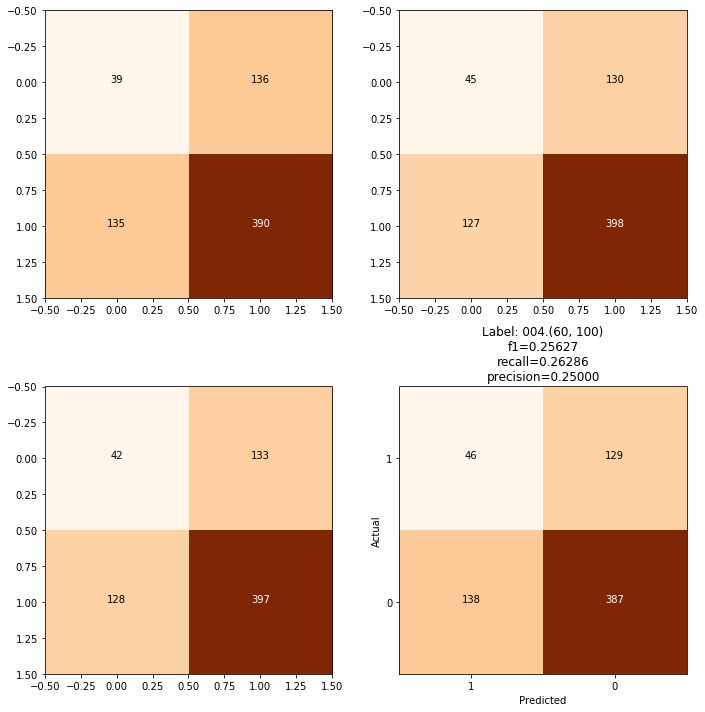

In [66]:
import sys
from sklearn.metrics import multilabel_confusion_matrix
import itertools

# Confusion Matrix: to display number of true positive, true negative, 
#     false positive, and false negative values for each model
def plot_conf_multiclass(y_true, y_pred, list_classes):
  fig, axes = plt.subplots(int(np.ceil(len(list_classes) / 2)), 2, figsize=(10, 10))
  axes = axes.flatten()
  multiclass_cm = multilabel_confusion_matrix(y_true, y_pred)
  for i, conf in enumerate(multiclass_cm):
    tn, fp, fn, tp = conf.ravel()
    f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
    recall = tp / (tp + fn + sys.float_info.epsilon)
    precision = tp / (tp + fp + sys.float_info.epsilon)
    conf_mat = np.array([[tp,fn],
                         [fp,tn]])
    
    # Define color of confusion matrix
    ax = axes[i]
    ax.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Oranges)
    
    # Define color of annotation
    for a, b in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
      ax.text(b, a, conf_mat[a, b],
              horizontalalignment="center",
              color="white" if conf_mat[a, b] > conf_mat.max() / 2. else "black")
  tick_marks = np.arange(2)
  ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(['1','0'])
  ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(['1','0'])
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  ax.set_title(f'Label: {list_classes[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}')
  ax.grid(False)
  plt.tight_layout()
  plt.plot()
    
  return multiclass_cm
  
multiclass_cm = plot_conf_multiclass(y_test_code, y_pred_code, list_classes)

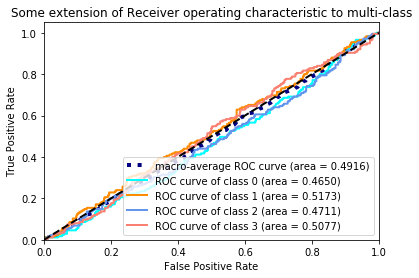

In [104]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp

# Method for plotting ROC curve for muliclassification: 
# to compare among models in term of the discrimination
def plot_roc_multiclass(y_true, y_prob, n_classes):
  
  # Compute ROC curve, ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
  # Compute macro-average ROC curve and ROC area
  # Aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
  # Interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Average it and compute the AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr["macro"], tpr["macro"],
           label = 'macro-average ROC curve (area = {:0.4f})'.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'salmon'])
  for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {} (area = {:0.4f})'.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

  return fpr, tpr, roc_auc

fpr, tpr, roc_auc = plot_roc_multiclass(y_test_code, y_prob, n_classes)

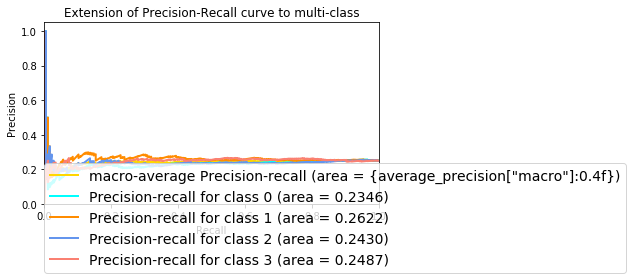

In [106]:
from sklearn.metrics import precision_recall_curve, average_precision_score


# Method for plotting PR Curve: to compare among models in term of the precision and recall
def plot_pr_multiclass(y_true, y_prob, n_classes):
    
  # Compute PR curve, and PR area for each class
  precision = dict()
  recall = dict()
  average_precision = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i],y_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_prob[:, i])

  # Compute macro-average PR curve and PR area
  # A "macro-average": quantifying score on average
  precision["macro"], recall["macro"], _ = precision_recall_curve(y_true.ravel(), y_prob.ravel())
  average_precision["macro"] = average_precision_score(y_true, y_prob, average="macro")


  # Plot all PR curves

  lines = []
  labels = []

  l, = plt.plot(recall["macro"], precision["macro"], color='gold', lw=2)
  lines.append(l)
  labels.append('macro-average Precision-recall (area = {average_precision["macro"]:0.4f})')

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'salmon'])
  for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.4f})'
                  ''.format(i, average_precision[i]))

  fig = plt.gcf()
  fig.subplots_adjust(bottom=0.25)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Extension of Precision-Recall curve to multi-class')
  plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

  return precision, recall, average_precision

precision, recall, average_precision = plot_pr_multiclass(y_test_code, y_prob, n_classes)

&emsp;&emsp;According to the confusion matrix, the true predicted values are also small compared to number of true negative predictive values. Therefore, area under the ROC and Precision-Recall curve will be low because these measures basically calculate on the positive predictive values.As a result, the macro-average area under the ROC curve among all classes is 0.4916, and the macro-average of Precision-Recall curve is 0.2428 which are quite low. Thus, the model has low performance to predict age group with a given facial image, but it has high accurate performance on negative prediction.

## **Section 7: Conclusion**
&emsp;&emsp;The model has high accuracy, but small area under the ROC and Precision-Recall curve. This is because a large number of  true negative predictive value, so the model could classify correctly in term of 'not in that age group'. Thus, it could be applied in another purpose of prediction. For example, if a private hospital has many packages of health promotion which are depending on aging. Health programs for elders are more expensive thant those for younger people due to aging. Elders also have a higher chance of purchasing the package, so the hospital will focus on this target group as well as the relatives and friends of these patients. Then the hospital apply this model with CCTV that has a function of face detection, the model will accurately classify, to focus on elder group, who is not in elders. Therefore, the seller team do not waste time for that people.